# Customer Lifecycle Management

## Introduction

This project focuses on **Customer Lifecycle Management** for a player-based dataset, aiming to analyze user behaviors, identify churn patterns, and optimize retention strategies.

The primary goals of the analysis are:

- **Understand player demographics and behavior patterns** across different seasons (Summer and Fall).
- **Segment players** by income level, customer type, and activity level.
- **Analyze churn rates** based on factors like seasonality, income, age group, and bonuses received.
- **Build a churn prediction model** using **XGBoost**, evaluate its performance using **ROC-AUC** and other metrics.
- **Identify the most important features** that contribute to player churn to inform targeted marketing and retention campaigns.

The dataset includes information about player sessions, spending, social engagement, bonuses, and demographic attributes. Through detailed exploratory data analysis (EDA), visualization, and modeling, the aim is to uncover actionable insights that can help in improving user retention and maximizing lifetime value.

In [61]:
import pandas as pd
import missingno
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from plotnine import *
import stepwise as stepwise
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from mizani.formatters import percent_format 
import sys 
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split

In [62]:
#Read in dataframes
customerdata = pd.read_csv('customerdata_case.csv',parse_dates=['Registrationdate'])
summersesstrx = pd.read_csv('summersesstrx_case.csv',parse_dates=['Date'])
summerfintrx = pd.read_csv('summerfintrx_case.csv',parse_dates=['Date'])

fallfintrx = pd.read_csv('fallfintrx_case.csv',parse_dates=['Date'])
fallsesstrx = pd.read_csv('fallsesstrx_case.csv',parse_dates=['Date'])

In [63]:
#convert datetime to date
summerfintrx['Date'] = pd.to_datetime(summerfintrx['Date']).dt.date
summersesstrx['Date'] = pd.to_datetime(summersesstrx['Date']).dt.date
fallfintrx['Date'] = pd.to_datetime(fallfintrx['Date']).dt.date
fallsesstrx['Date'] = pd.to_datetime(fallsesstrx['Date']).dt.date
customerdata['Registrationdate'] = pd.to_datetime(customerdata['Registrationdate']).dt.date

In [64]:
#preset wave in customer dataframe
def setwave(registrationdate):
    if(registrationdate<datetime.datetime.strptime('01/01/2021','%d/%m/%Y').date()):
        return 1
    elif(registrationdate<datetime.datetime.strptime('01/01/2022','%d/%m/%Y').date()):
        return 2
    else:
        return 3

In [65]:
customerdata['Wave']=customerdata['Registrationdate'].apply(lambda x: setwave(x))
StartDate=datetime.datetime.strptime('01/05/2022','%d/%m/%Y').date()
EndDate=datetime.datetime.strptime('31/08/2022','%d/%m/%Y').date()
LaunchDate=datetime.datetime.strptime('01/07/2018','%d/%m/%Y').date()
valueproduct=[2.99,4.99,9.99,25,99]

In [66]:
#Label customer types
customer_type_labels = {
    1: "Walkers",
    2: "Miscellaneous",
    3: "Socials",
    4: "Grinders"
}
#Label Income Level
income_map = {1: "Low", 2: "Medium", 3: "High"}
#Label Gender
gender_map = {0: "Male", 1: "Female"}
#Label Fall Bonus
fallbonus_map = {0: "No", 1: "Yes"}
#Label Product Price
product_map = {1: 2.99, 2:4.99, 3:9.99, 4:25, 5:99}

In [67]:
customerdata['CustomerTypeLabel'] = customerdata['CustomerType'].map(customer_type_labels)
customerdata['GenderLabel'] = customerdata['Gender'].map(gender_map)
customerdata["IncomeLabel"] = customerdata["Income"].map(income_map)
customerdata['FallbonusLabel'] = customerdata['fallbonus'].map(fallbonus_map)
summerfintrx["Amount"] = summerfintrx["ProductID"].map(product_map)
fallfintrx["Amount"] = fallfintrx["ProductID"].map(product_map)

In [68]:
summersesstrx_df = pd.merge(summersesstrx, customerdata, on = "CustomerID")
fallsesstrx_df = pd.merge(fallsesstrx, customerdata, on = "CustomerID")

In [69]:
summerfintrx_df = pd.merge(summerfintrx, customerdata, on = "CustomerID")
fallfintrx_df = pd.merge(fallfintrx, customerdata, on = "CustomerID")

In [70]:
summer_df = pd.merge(summersesstrx_df, summerfintrx, on = "CustomerID")
fall_df = pd.merge(fallsesstrx_df, fallfintrx, on = "CustomerID")

In [71]:
summer_summary = summer_df.groupby("CustomerID").agg({
    "PlayID": "count",
    "Experience": "mean",
    "Huntingcabins": "mean",
    "Trainingschools": "mean",
    "Huntinggrounds": "mean",
    "Social": "mean",
    "Monsters": "mean",
    "Distance": "mean",
    "Duration": "mean",
    "Amount": "sum"
}).reset_index()
summer_summary = summer_summary.rename(columns = lambda x: "summer_" + x if x != "CustomerID" else x)

In [72]:
fall_summary = fall_df.groupby("CustomerID").agg({
    "PlayID": "count",
    "Experience": "mean",
    "Huntingcabins": "mean",
    "Trainingschools": "mean",
    "Huntinggrounds": "mean",
    "Social": "mean",
    "Monsters": "mean",
    "Distance": "mean",
    "Duration": "mean",
    "Amount": "sum",
}).reset_index()

fall_summary = fall_summary.rename(columns=lambda x: "fall_" + x if x != "CustomerID" else x)

In [73]:
df_all = customerdata.merge(summer_summary, on = "CustomerID", how = "left").merge(fall_summary, on = "CustomerID", how = "left")
df_all = df_all.fillna(0)

In [74]:
df_all["AgeGroup"] = pd.cut(
    df_all["Age"],
    bins=[0, 25, 40, 60, 100],
    labels=["<25", "25–40", "40–60", "60+"]
)

In [75]:
print(df_all.columns)

Index(['CustomerID', 'CustomerType', 'Registrationdate', 'Gender', 'Age',
       'fallbonus', 'Income', 'Wave', 'CustomerTypeLabel', 'GenderLabel',
       'IncomeLabel', 'FallbonusLabel', 'summer_PlayID', 'summer_Experience',
       'summer_Huntingcabins', 'summer_Trainingschools',
       'summer_Huntinggrounds', 'summer_Social', 'summer_Monsters',
       'summer_Distance', 'summer_Duration', 'summer_Amount', 'fall_PlayID',
       'fall_Experience', 'fall_Huntingcabins', 'fall_Trainingschools',
       'fall_Huntinggrounds', 'fall_Social', 'fall_Monsters', 'fall_Distance',
       'fall_Duration', 'fall_Amount', 'AgeGroup'],
      dtype='object')


In [76]:
print(summer_df.columns)

Index(['PlayID', 'Date_x', 'CustomerID', 'Experience', 'Huntingcabins',
       'Trainingschools', 'Huntinggrounds', 'Social', 'Monsters', 'Distance',
       'Duration', 'CustomerType', 'Registrationdate', 'Gender', 'Age',
       'fallbonus', 'Income', 'Wave', 'CustomerTypeLabel', 'GenderLabel',
       'IncomeLabel', 'FallbonusLabel', 'TransID', 'Date_y', 'ProductID',
       'Amount'],
      dtype='object')


In [77]:
sns.set_theme(style="whitegrid", palette="rocket_r")

## Player Profile Analysis

### Player Profile Overview

#### Age Distribution

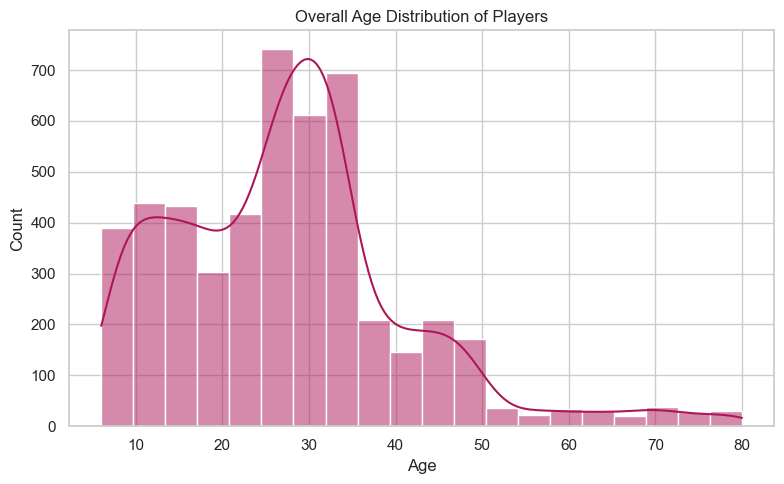

In [81]:
color = sns.color_palette("rocket_r")[3]

plt.figure(figsize=(8, 5))
sns.histplot(customerdata["Age"], bins=20, kde=True, color=color)
plt.title("Overall Age Distribution of Players")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- Our **primary player** base is concentrated between ages **20 and 35**, making this group the most valuable target for monetization and retention efforts
- Although players **under 18** make up a noticeable portion of the user base, they are less likely to convert, and strategies for this group should focus on **long-term engagement and nurturing** rather than immediate spending
- Older players **aged 50 and above** represent a small, fluctuating segment. While they may offer insights for long-term user behavior, they are not ideal for high-investment marketing or monetization strategies.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/4292395593.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



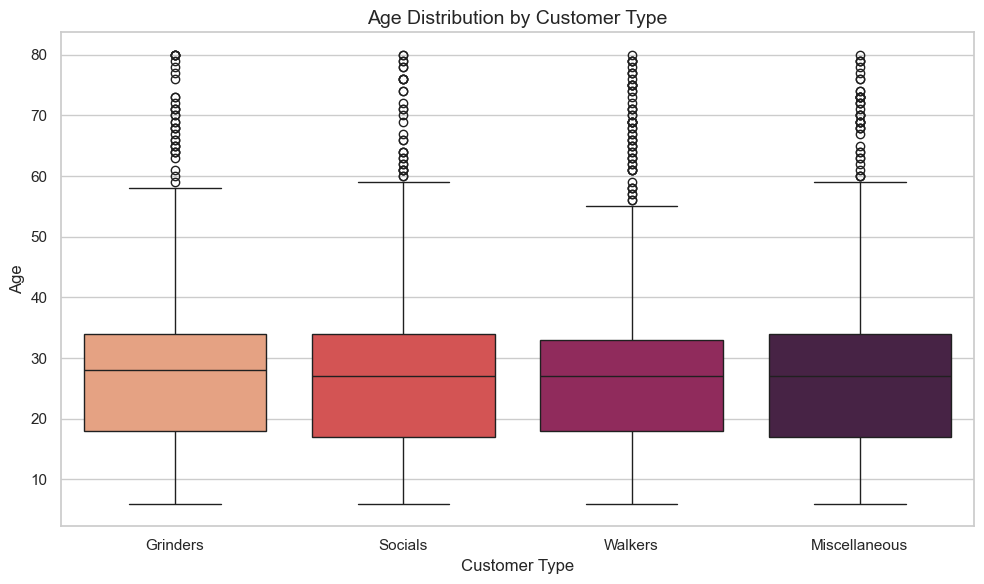

In [133]:
sns.set_theme(style="whitegrid", palette="rocket_r")
colors = sns.color_palette("rocket_r", n_colors=4)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=customerdata,         
    x="CustomerTypeLabel",
    y="Age",
    palette= colors
)
plt.title("Age Distribution by Customer Type", fontsize=14)
plt.xlabel("Customer Type")
plt.ylabel("Age")
plt.tight_layout()
plt.show()

* **Key Findings**
    - The **median age** across all customer types is **similar**, around **27 to 30 years old**
    - The interquatile ranges are almost identical, indicating similar age spread across types
    - Each type exhibits outliers aged 60+, suggesting the presence of senior players
    - overall age range spans from approximately 5 to 60 year old
    - **No significant age differences** between customer types
* **Conclusion**
    - Customer segmentation appears to be driven more by behavior, interests, or lifestyle rather than age
    - The **core target group** is age <u>25-35</u>, who should be prioritized for engagement and monetization strategies
    - Meanwhile, the presence of older players(>50) suggests there is also room to consider special adaptations for senior users

#### Income Distribution

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3559814702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



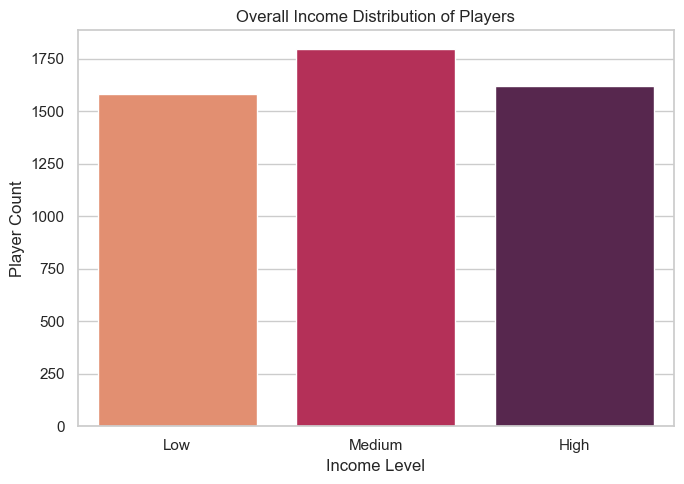

In [86]:
plt.figure(figsize=(7, 5))
sns.countplot(x="IncomeLabel", data=customerdata, palette="rocket_r")
plt.title("Overall Income Distribution of Players")
plt.xlabel("Income Level")
plt.ylabel("Player Count")
plt.tight_layout()
plt.show()

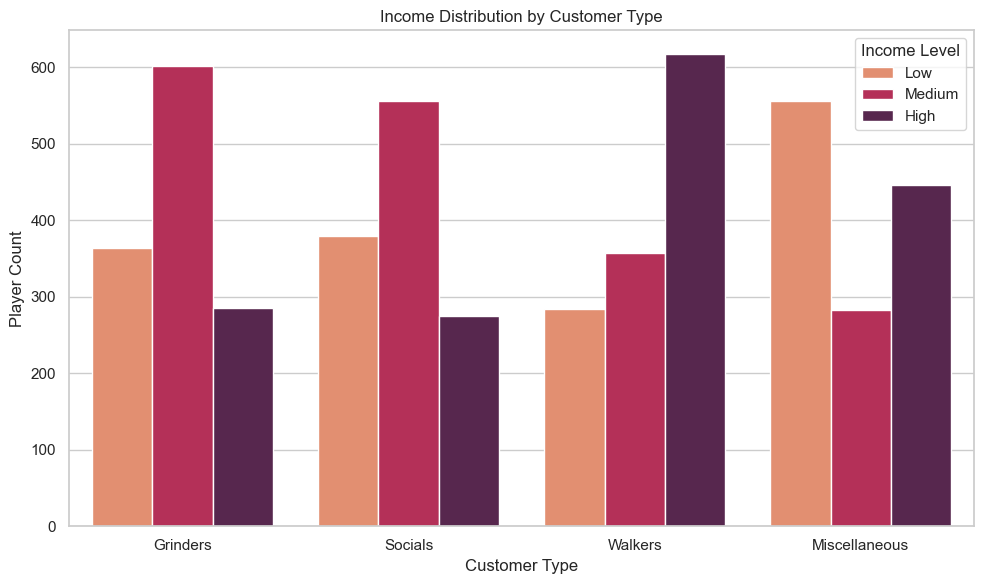

In [87]:
# Income Distribution By Customer Type
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customerdata,
    x="CustomerTypeLabel",
    hue="IncomeLabel",
    palette="rocket_r"
)
plt.title("Income Distribution by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Player Count")
plt.legend(title="Income Level")
plt.tight_layout()
plt.show()

##### 📊 Income Analysis Summary

The two plots together provide important insights into the income distribution of players:

- **Overall Distribution**:  
  The majority of players belong to the **Medium income** group, followed by the **Low income** group, and then the **High income** group. This suggests that the platform has a strong middle-class user base, but also a significant number of players from lower and higher income brackets.

- **By Customer Type**:  
  Different customer types show distinct income patterns:
  - **Walkers** have a higher concentration of **High income** players, making them ideal targets for premium products and services.
  - **Grinders** and **Socials** are mostly **Medium income** players, implying a steady, reliable customer base suited for volume-based loyalty programs.
  - **Miscellaneous** players display a balanced spread across all income levels, indicating the need for personalized engagement strategies.

##### 🧠 Key Insights:
- **Middle-income players** form the backbone of the user base.
- **High-income Walkers** represent a lucrative segment for upselling premium offerings.
- **Grinders and Socials** should be nurtured with consistent rewards and mid-tier product options.

##### 🎯 Strategic Recommendations:
1. **Segmented Marketing**: Customize promotions based on both **customer type** and **income level** for better targeting and ROI.
2. **Premium Offerings**: Design high-end products and exclusive experiences aimed at **high-income Walkers**.
3. **Accessible Deals**: Offer affordable packages or seasonal discounts to **low-income players** to enhance conversion and retention.

#### Gender Distribution

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3240583814.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



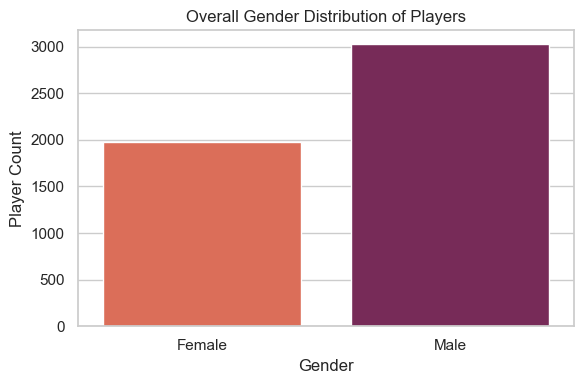

In [90]:
plt.figure(figsize=(6, 4))
sns.countplot(x="GenderLabel", data=customerdata, palette="rocket_r")
plt.title("Overall Gender Distribution of Players")
plt.xlabel("Gender")
plt.ylabel("Player Count")
plt.tight_layout()
plt.show()

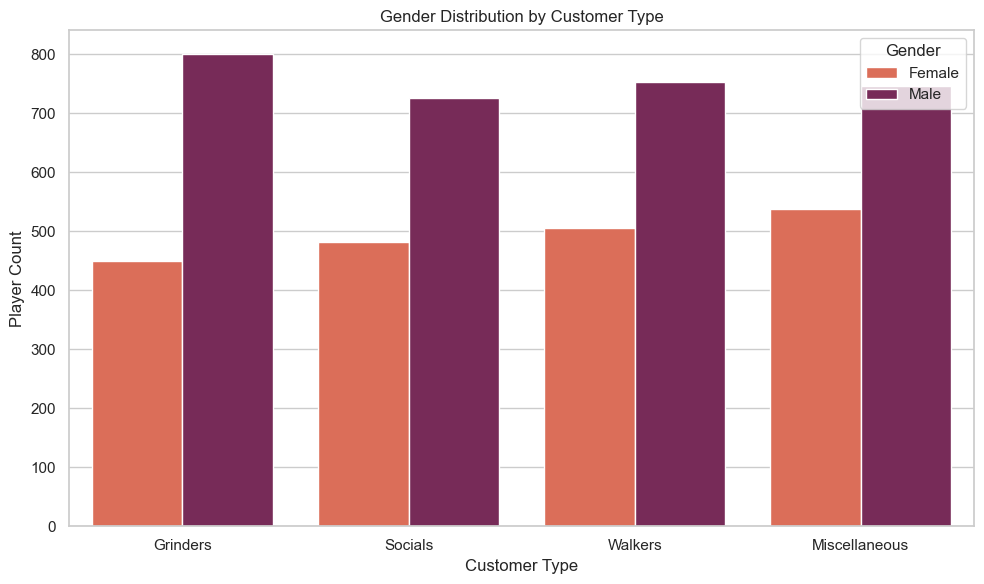

In [91]:
# Gnender Distribution By Customer Type
plt.figure(figsize=(10, 6))
sns.countplot(
    data=customerdata,
    x="CustomerTypeLabel",
    hue="GenderLabel",
    palette="rocket_r"
)
plt.title("Gender Distribution by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Player Count")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

##### 📊 Gender Analysis Summary

The two plots collectively show the gender distribution of players overall and by customer type:

- **Overall Gender Distribution**:  
  There are significantly more **male players** compared to female players. This indicates a male-dominant player base.

- **By Customer Type**:
  - Across all customer types, **male players consistently outnumber female players**.
  - The **Grinders** and **Walkers** customer types show the most noticeable male dominance.
  - The **Miscellaneous** group has a relatively more balanced gender distribution, although males still lead.

##### 🧠 Key Insights:
- The platform's audience is predominantly **male**, regardless of customer segmentation.
- Female players are underrepresented but still represent an important segment, especially within the Miscellaneous category.

##### 🎯 Strategic Recommendations:
1. **Deepen Male Player Engagement**:  
   Focus on enhancing game features, designs, and narratives that resonate with the preferences and behaviors of male players.
2. **Tailored Content Development**:  
   Prioritize content themes, competitive features, and reward mechanisms that align with male gaming motivations such as achievement, competition, and status.
3. **Competitive Community Building**:  
   Foster highly competitive and skill-based communities/events that appeal to the core male audience.
4. **Optional Inclusivity Enhancements**:  
   Maintain inclusivity elements for female players without diverting core resources, ensuring the environment remains welcoming but without diluting the male-focused experience.
5. **Continuous Behavioral Analytics**:  
   Regularly track and analyze male player behaviors and preferences to fine-tune future game updates and marketing strategies.

#### Radar Chart of Player Behavior By Type

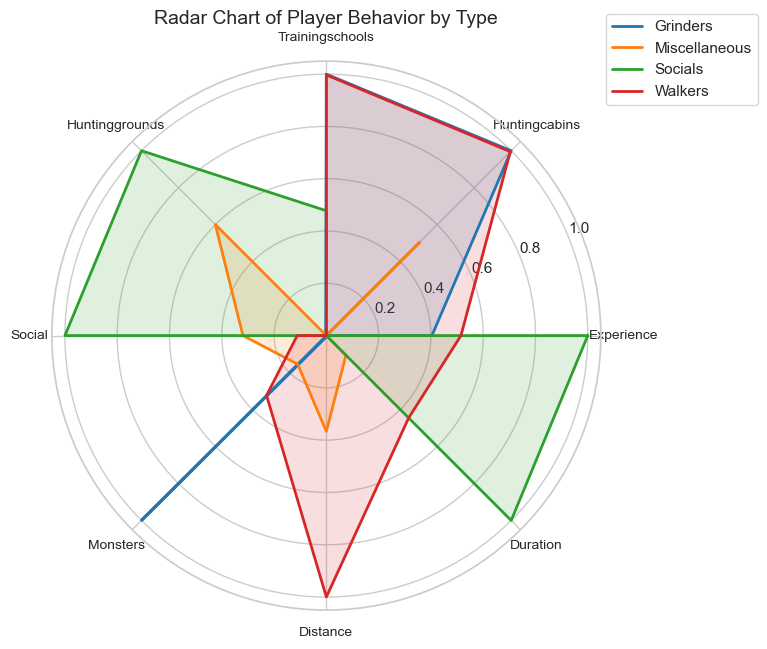

In [94]:
behavior_cols = [
    "Experience", "Huntingcabins", "Trainingschools", "Huntinggrounds",
    "Social", "Monsters", "Distance", "Duration"
]

radar_data = summersesstrx_df.groupby("CustomerTypeLabel")[behavior_cols].mean()
radar_data_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())

colors = sns.color_palette("tab10", n_colors=len(radar_data_norm))

# Radar Plot
labels = radar_data.columns.tolist()
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))

#Each lines
for idx, (label, row) in enumerate(radar_data_norm.iterrows()):
    values = row.tolist() + row.tolist()[:1]
    plt.polar(angles, values, label=label, color=colors[idx], linewidth=2)
    plt.fill(angles, values, alpha=0.15, color=colors[idx])

plt.xticks(angles[:-1], labels, fontsize=10)
plt.title("Radar Chart of Player Behavior by Type", fontsize=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

##### 📊 Player Behavior Analysis by Customer Type

The radar chart illustrates the behavioral patterns of different customer types (Grinders, Miscellaneous, Socials, Walkers) across multiple activity dimensions, including Experience, Huntingcabins, Trainingschools, Huntinggrounds, Social, Monsters, Distance, and Duration.

##### 🧠 Key Insights:
- **Socials**:  
  Social players show the highest engagement in **Experience** and **Social** activities, suggesting they prefer interactive, community-driven features.
- **Walkers**:  
  Walkers demonstrate high values in **Huntingcabins**, **Trainingschools**, and **Distance**, indicating a strong focus on exploration and skill-building.
- **Grinders**:  
  Grinders stand out in **Monsters** hunting, emphasizing their preference for challenge and competition-driven gameplay.
- **Miscellaneous**:  
  Miscellaneous players show moderate or low engagement across all activities, indicating a diverse but generally less specialized behavior pattern.

##### 🎯 Strategic Recommendations:
1. **Tailored Game Content**:  
   Develop specialized in-game features or events that align with each customer type’s dominant behavior:
   - Competitive monster hunts for **Grinders**
   - Exploration-based missions and achievements for **Walkers**
   - Social interaction platforms or guild systems for **Socials**
2. **Personalized Engagement Strategies**:  
   Send customized event invitations or promotions based on player behavior clusters to maximize participation and retention.
3. **Behavior-Driven Rewards**:  
   Introduce achievement systems that reward players for excelling in their preferred activities, enhancing long-term loyalty.
4. **Targeted Expansion**:  
   Design cross-type events that encourage players to experience other activity types, broadening overall engagement.

## Seasonal Behavior Analysis
This section analyzes player behavior and spending differences between Summer and Fall seasons.

### 🧠 Key Insights:

- **Decrease in Play Sessions and Duration**:  
  On average, players showed a **decrease in both total play sessions and total play duration** from Summer to Fall, suggesting seasonal disengagement or shifting interests.

- **Reduced Spending**:  
  Total spending in Fall ($43,585.04) was significantly lower than in Summer ($107,262.86), a decrease of more than 50%. This sharp drop indicates a major seasonal impact on monetization.

- **Behavioral Shifts**:  
  Across key indicators (e.g., Experience, Monsters, Distance, Duration):
  - Most behavior metrics **slightly decreased** in Fall compared to Summer.
  - **Experience** dropped the most (-34.39 points), reflecting lower engagement levels.
  - **Social interactions** and **combat activities (Monsters)** also saw minor declines.

- **Cohort Differences (Wave Analysis)**:  
  - Players registered in different periods (Wave 1, Wave 2, Wave 3) showed similar seasonal behavior patterns.
  - However, newer players (Wave 3) had relatively **higher play duration** in Fall, suggesting fresher cohorts may be more resilient to seasonal decline.

- **Top Players**:  
  About **20% of players** who were active in Summer became silent (no sessions) in Fall, highlighting a significant seasonal churn risk.
  - Top 10% session players and spenders were relatively consistent between seasons, suggesting a loyal core user base.

### 🎯 Strategic Recommendations:

1. **Seasonal Retention Campaigns**:  
   Launch targeted retention campaigns before and during the Fall season to minimize seasonal churn.

2. **Fall Engagement Events**:  
   Introduce special Fall-themed events and activities to stimulate engagement during low-activity periods.

3. **Focus on Loyal Cohorts**:  
   Identify and nurture high-value players (top 10%) through VIP programs, loyalty rewards, and personalized offers.

4. **New Player Nurturing**:  
   Invest in onboarding and early engagement strategies for newer players (Wave 3), who show greater resilience to seasonal drop-offs.

5. **Behavior Monitoring**:  
   Continue to monitor key behavior KPIs (Experience, Distance, Social) across seasons to preemptively adjust engagement strategies.

In [97]:
# Changes in duration of play
df_all["change_total_sessions"] = df_all['fall_PlayID'] - df_all['summer_PlayID']
df_all["change_total_duration"] = df_all["fall_Duration"] - df_all["summer_Duration"]
print(df_all[["change_total_sessions", "change_total_duration"]].mean())

change_total_sessions   -1.276600
change_total_duration   -1.395848
dtype: float64


In [98]:
# Mean Changes in Group Behavior in Summer and Autumn
wave_behavior_change = df_all.groupby("Wave")[
    ["change_total_sessions", "change_total_duration"]
].mean()

print(wave_behavior_change)

      change_total_sessions  change_total_duration
Wave                                              
1                 -1.011708               4.567479
2                 -0.864162               2.974117
3                 -1.600398              -6.652731


In [99]:
# number of consumers
summer_payers = (df_all["summer_Amount"]>0).sum()
fall_payers = (df_all["fall_Amount"]>0).sum()

summer_total_spent = df_all["summer_Amount"].sum()
fall_total_spent = df_all["fall_Amount"].sum()

print(f"Summer Payers: {summer_payers}, Total Spent: {summer_total_spent}")
print(f"Fall Payers: {fall_payers}, Total Spent: {fall_total_spent}")

Summer Payers: 1711, Total Spent: 107262.86
Fall Payers: 1684, Total Spent: 45305.04


In [100]:
# Change in individual behavior indicators
summer_cols = [f"summer_{col}" for col in behavior_cols]
fall_cols = [f"fall_{col}" for col in behavior_cols]

summer_means = df_all[summer_cols].mean()
fall_means = df_all[fall_cols].mean()

delta_means = fall_means.values - summer_means.values

summary_table = pd.DataFrame({
    "Summer Avg": summer_means.values,
    "Fall Avg": fall_means.values,
    "Fall - Summer Change": delta_means
}, index=behavior_cols)

summary_table = summary_table.round(2)
print(summary_table)

                 Summer Avg  Fall Avg  Fall - Summer Change
Experience          1536.05   1501.66                -34.39
Huntingcabins          5.35      5.31                 -0.04
Trainingschools        2.55      2.54                 -0.01
Huntinggrounds         0.24      0.22                 -0.02
Social                 0.38      0.35                 -0.02
Monsters               6.43      6.44                  0.01
Distance               1.23      1.21                 -0.01
Duration              21.94     20.54                 -1.40


In [101]:
# Statistics of average summer and autumn behaviors by player type
summer_behavior_by_type = df_all.groupby("CustomerTypeLabel")[[f"summer_{col}" for col in behavior_cols]].mean()
fall_behavior_by_type = df_all.groupby("CustomerTypeLabel")[[f"fall_{col}" for col in behavior_cols]].mean()

behavior_change_by_type = fall_behavior_by_type.values - summer_behavior_by_type.values
print(pd.DataFrame(behavior_change_by_type, index=summer_behavior_by_type.index, columns=behavior_cols))


                   Experience  Huntingcabins  Trainingschools  Huntinggrounds  \
CustomerTypeLabel                                                               
Grinders           152.932309       0.257097         0.119126        0.107844   
Miscellaneous      215.079031       0.766097         0.567255       -0.027032   
Socials           -652.790026      -1.268487        -0.829070       -0.282904   
Walkers            118.657112       0.022329         0.052317        0.096573   

                     Social  Monsters  Distance   Duration  
CustomerTypeLabel                                           
Grinders           0.140694 -1.073544  0.339474   7.116751  
Miscellaneous      0.074049  1.304783  0.103077   6.419263  
Socials           -0.445663 -0.962267 -0.033989 -21.093297  
Walkers            0.114544  0.679240 -0.463623   1.083615  


In [102]:
# Silent after summer
silent_after_summer = ((df_all["summer_PlayID"] > 0) & (df_all["fall_PlayID"] == 0)).sum()
total_summer_players = (df_all["summer_PlayID"] > 0).sum()

print(f"Silent after Summer: {silent_after_summer} / {total_summer_players} ({silent_after_summer/total_summer_players*100:.2f}%)")

Silent after Summer: 343 / 1711 (20.05%)


In [103]:
#Summer Session
session_threshold = df_all["summer_PlayID"].quantile(0.9)
top_session_players = df_all[df_all["summer_PlayID"] >= session_threshold]
print(f"Summer Top 10% Session Number of players：{len(top_session_players)}")

#Fall Session
amount_threshold = df_all["summer_Amount"].quantile(0.9)
top_spending_players = df_all[df_all["summer_Amount"] >= amount_threshold]
print(f"Fall Top 10% Session Number of players：{len(top_spending_players)}")

Summer Top 10% Session Number of players：528
Fall Top 10% Session Number of players：514


In [104]:
#Summer spending
summer_spending_threshold = df_all["summer_Amount"].quantile(0.9)
top_summer_spenders = df_all[df_all["summer_Amount"] >= summer_spending_threshold]
print(f"Summer Top 10% Number of players：{len(top_summer_spenders)}")

#Fall Spending
fall_spending_threshold = df_all["fall_Amount"].quantile(0.9)
top_fall_spenders = df_all[df_all["fall_Amount"] >= fall_spending_threshold]
print(f"Fall Top 10% Number of players：{len(top_fall_spenders)}")

Summer Top 10% Number of players：514
Fall Top 10% Number of players：509


In [105]:
def set_wave(registration_date):
    date = pd.to_datetime(registration_date).date()
    if date < datetime.date(2021, 1, 1):
        return "Wave 1 (before 2021)"
    elif date < datetime.date(2022, 1, 1):
        return "Wave 2 (2021)"
    else:
        return "Wave 3 (2022)"

# Label
summersesstrx_df["Wave"] = summersesstrx_df["Registrationdate"].apply(set_wave)
fallsesstrx_df["Wave"] = fallsesstrx_df["Registrationdate"].apply(set_wave)

summersesstrx_df["Season"] = "Summer"
fallsesstrx_df["Season"] = "Fall"

# Merge data
session_all = pd.concat([summersesstrx_df, fallsesstrx_df], axis=0)

# Behaviors for analysis
behavior_cols = [
    "Experience", "Huntingcabins", "Trainingschools",
    "Huntinggrounds", "Social", "Monsters", "Distance", "Duration"
]

# calculate mean values
wave_season_behavior = session_all.groupby(["Wave", "Season"])[behavior_cols].mean().reset_index()

display(wave_season_behavior)

,Wave,Season,Experience,Huntingcabins,Trainingschools,Huntinggrounds,Social,Monsters,Distance,Duration
0,Wave 1 (before 2021),Fall,4463.779030,15.513529,7.432356,0.700958,1.133033,18.414882,3.533116,57.911413
1,Wave 1 (before 2021),Summer,4427.419296,16.809681,7.766397,0.413514,0.727738,21.637866,3.926967,44.360476
2,Wave 2 (2021),Fall,4519.888843,15.425550,7.408959,0.767316,1.108669,18.489009,3.533176,49.015193
3,Wave 2 (2021),Summer,4371.294014,15.591816,6.945693,0.728719,1.027027,17.833796,3.767458,40.213235
4,Wave 3 (2022),Fall,4465.796770,15.563305,7.411785,0.678749,1.133310,18.807078,3.595065,72.878795
5,Wave 3 (2022),Summer,4583.292042,14.649291,7.439005,0.903280,1.481023,17.027648,3.121546,89.628631


### Visualiztaion

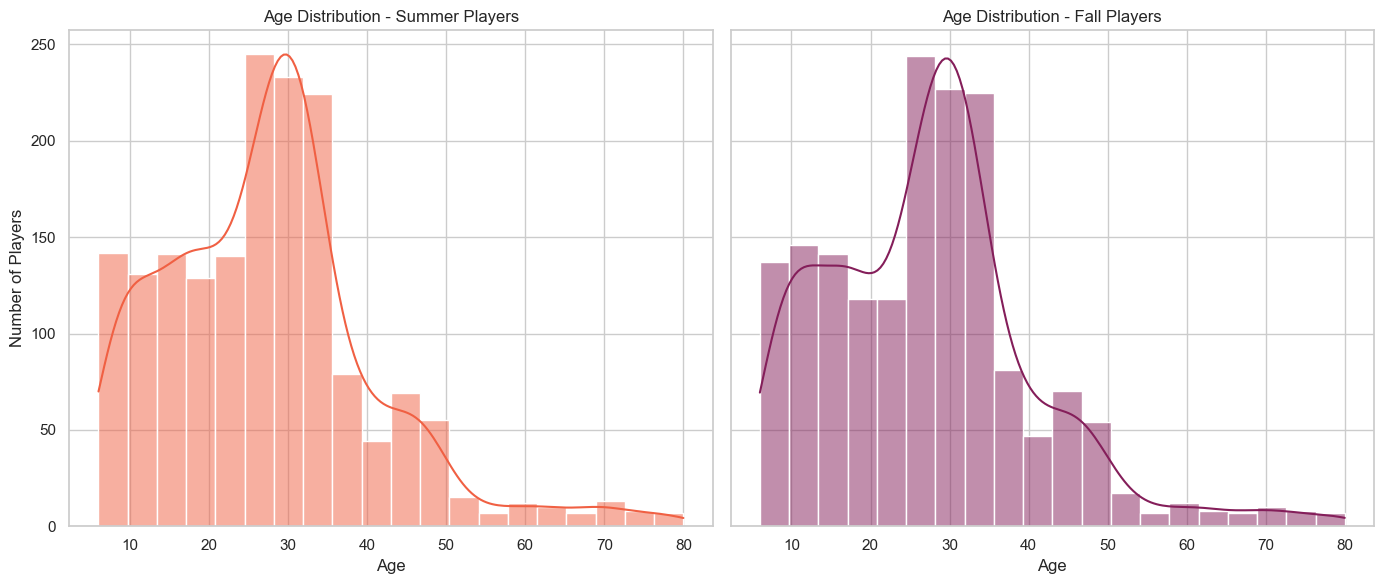

In [107]:
palette = sns.color_palette("rocket_r", n_colors=2)

summer_active = df_all[df_all["summer_PlayID"] > 0]
fall_active = df_all[df_all["fall_PlayID"] > 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Summer Age Distribution 
sns.histplot(
    data=summer_active, 
    x="Age", 
    bins=20, 
    kde=True, 
    color=palette[0], 
    ax=axes[0]
)
axes[0].set_title("Age Distribution - Summer Players")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Number of Players")

# Fall Age Distribution
sns.histplot(
    data=fall_active, 
    x="Age", 
    bins=20, 
    kde=True, 
    color=palette[1],
    ax=axes[1]
)
axes[1].set_title("Age Distribution - Fall Players")
axes[1].set_xlabel("Age")

plt.tight_layout()
plt.show()

##### 📊 Age Distribution Analysis (Summer vs Fall Players)

The histograms show the age distribution of active players in the Summer and Fall.


##### 🧠 Key Insights:

- **Core Audience**:  
  Most players are between **20 and 35 years old**, with a peak in the late 20s.
  
- **Stable Distribution**:  
  The overall shape is similar across seasons, though Fall sees a **slight shift toward younger players** (ages 20–25).

- **Older Players**:  
  Players aged 40+ slightly decreased in Fall.


##### 🎯 Strategic Recommendations:

1. **Target 20–35 Age Group**:  
   Focus content and campaigns on the core demographic.

2. **Support Younger Growth**:  
   Enhance onboarding for younger players.

3. **Retain Older Players**:  
   Offer casual play modes or loyalty rewards to keep older users engaged.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3038229281.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3038229281.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



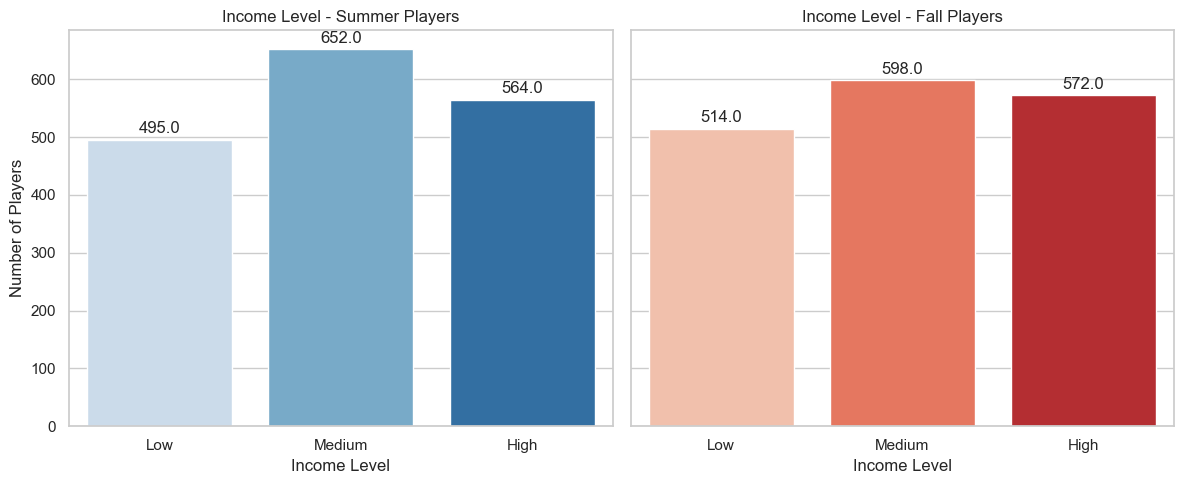

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Summer Income Distribution
summer_plot = sns.countplot(data=summer_active, x="IncomeLabel", palette="Blues", ax=axes[0])
axes[0].set_title("Income Level - Summer Players")
axes[0].set_xlabel("Income Level")
axes[0].set_ylabel("Number of Players")

for p in summer_plot.patches:
    axes[0].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 8), 
                     textcoords='offset points')

# Fall Income Distribution 
fall_plot = sns.countplot(data=fall_active, x="IncomeLabel", palette="Reds", ax=axes[1])
axes[1].set_title("Income Level - Fall Players")
axes[1].set_xlabel("Income Level")

for p in fall_plot.patches:
    axes[1].annotate(f'{p.get_height()}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 8), 
                     textcoords='offset points')

plt.tight_layout()
plt.show()

##### 📊 Income Level Distribution (Summer vs Fall Players)

These bar plots compare the income level distribution of active players between Summer and Fall.

##### 🧠 Key Insights:

- **Medium Income Dominance**:  
  Most players fall into the **Medium income** group in both Summer and Fall.

- **Stable Structure**:  
  Income distribution is relatively stable across seasons, with only minor shifts.

- **Slight Growth in Low Income**:  
  The number of **Low income** players slightly increased from Summer to Fall.


##### 🎯 Strategic Recommendations:

1. **Focus on Medium Income Group**:  
   Target marketing and offers primarily to the medium-income players.

2. **Inclusive Pricing**:  
   Introduce accessible entry-level promotions to engage the growing low-income segment.

3. **Maintain Premium Options**:  
   Keep offering high-end packages to retain high-income players.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/1398727631.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/1398727631.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



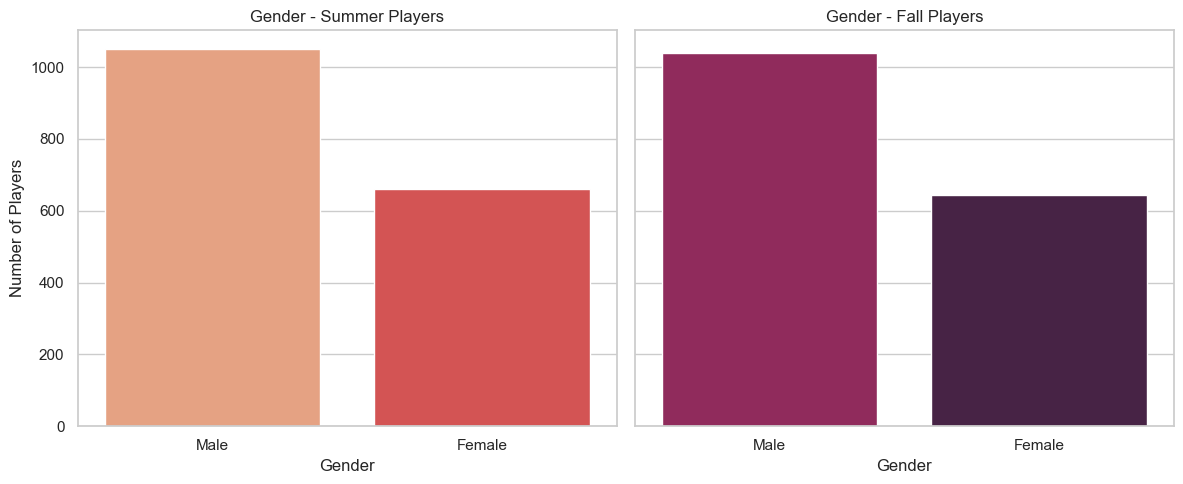

In [111]:
sns.set_theme(style="whitegrid", palette="rocket_r")
colors = sns.color_palette("rocket_r", n_colors=4)

gender_order = ["Male", "Female"]

summer_colors = {
    "Male": colors[0],
    "Female": colors[1]
}

fall_colors = {
    "Male": colors[2],
    "Female": colors[3]
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Summer Gender Distribution
summer_plot = sns.countplot(
    data=summer_active,
    x="GenderLabel",
    order=gender_order,
    palette=summer_colors,
    ax=axes[0]
)
axes[0].set_title("Gender - Summer Players")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Number of Players")

# Fall Gender Distribution
fall_plot = sns.countplot(
    data=fall_active,
    x="GenderLabel",
    order=gender_order,
    palette=fall_colors,
    ax=axes[1]
)
axes[1].set_title("Gender - Fall Players")
axes[1].set_xlabel("Gender")

plt.tight_layout()
plt.show()

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3350341681.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3350341681.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



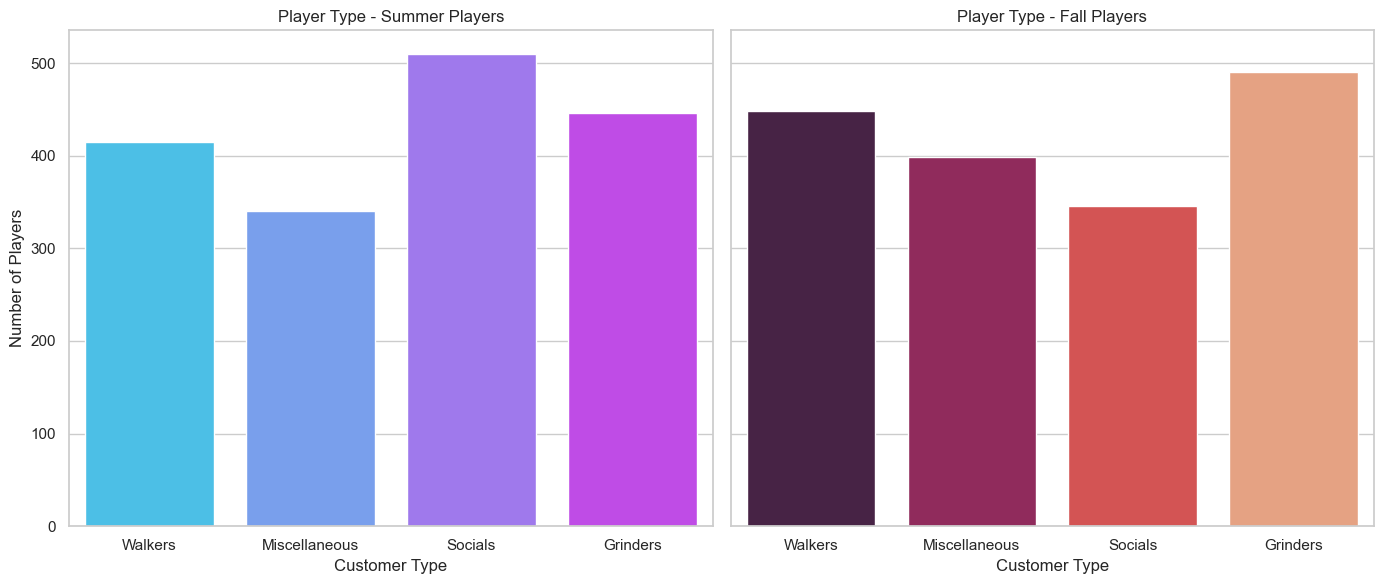

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Summer Player Types
sns.countplot(data=summer_active, x="CustomerTypeLabel", order=["Walkers", "Miscellaneous", "Socials", "Grinders"], palette="cool", ax=axes[0])
axes[0].set_title("Player Type - Summer Players")
axes[0].set_xlabel("Customer Type")
axes[0].set_ylabel("Number of Players")

# Fall Player Types
sns.countplot(data=fall_active, x="CustomerTypeLabel", order=["Walkers", "Miscellaneous", "Socials", "Grinders"], palette="rocket", ax=axes[1])
axes[1].set_title("Player Type - Fall Players")
axes[1].set_xlabel("Customer Type")

plt.tight_layout()
plt.show()

### 📊 Player Type Distribution (Summer vs Fall Players)

These bar plots show the distribution of player types across Summer and Fall seasons.

### 🧠 Key Insights:

- **Grinders**:  
  Grinders are the largest player group in both seasons, growing even more in Fall.

- **Walkers**:  
  Walkers maintain strong numbers, but show a slight drop from Summer to Fall.

- **Socials**:  
  Social players decreased significantly in Fall, suggesting reduced social engagement.

### 🎯 Strategic Recommendations:

1. **Support Grinders**:  
   Focus content and events on competition and achievement to retain and grow this core group.

2. **Re-engage Socials**:  
   Introduce social-driven features or community events to reactivate Social players.

3. **Diversify Player Activities**:  
   Create cross-type events that appeal to both Walkers and Grinders to maximize participation.

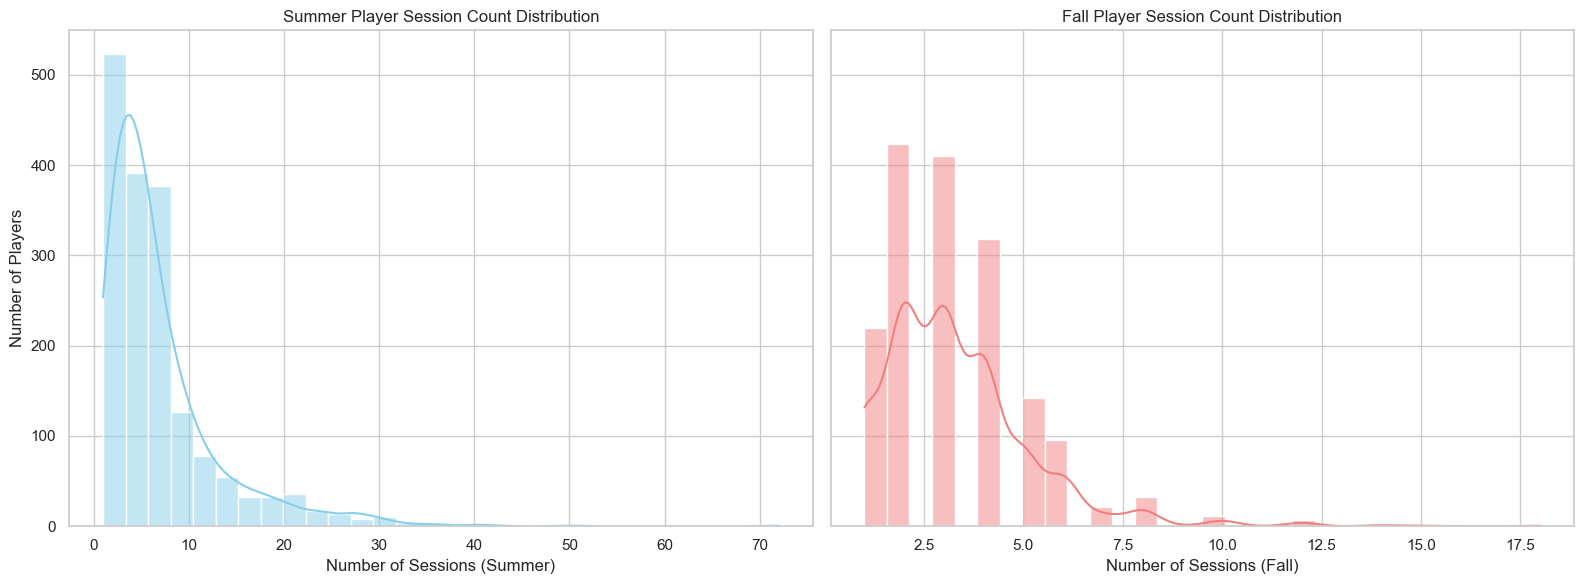

In [114]:
summer_active = df_all[df_all["summer_PlayID"] > 0]
fall_active = df_all[df_all["fall_PlayID"] > 0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# 画 Summer Session Distribution 
sns.histplot(
    data=summer_active,
    x="summer_PlayID",
    bins=30,
    kde=True,
    color="skyblue",
    ax=axes[0]
)
axes[0].set_title("Summer Player Session Count Distribution")
axes[0].set_xlabel("Number of Sessions (Summer)")
axes[0].set_ylabel("Number of Players")

# Fall Session Distribution 
sns.histplot(
    data=fall_active,
    x="fall_PlayID",
    bins=30,
    kde=True,
    color="lightcoral",
    ax=axes[1]
)
axes[1].set_title("Fall Player Session Count Distribution")
axes[1].set_xlabel("Number of Sessions (Fall)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

### 📊 Player Session Count Distribution (Summer vs Fall Players)

These histograms show the distribution of player session counts during Summer and Fall.

### 🧠 Key Insights:

- **Higher Activity in Summer**:  
  Players had more sessions during Summer, with a longer tail of highly active users.

- **Drop in Fall**:  
  In Fall, the number of sessions per player decreased, and most players had fewer sessions overall.

- **Shift Toward Low Activity**:  
  Fall players concentrated more around 2–5 sessions, indicating lower engagement.


### 🎯 Strategic Recommendations:

1. **Seasonal Engagement Boost**:  
   Launch events or incentives during Fall to encourage more frequent sessions.

2. **Retention Focus**:  
   Identify and support high-session players to maintain their activity through personalized rewards.

3. **Monitor Drop-off**:  
   Track session counts seasonally to detect and address early signs of disengagement.

## Analysis of Behavior and Payment Models

In [117]:
#Products price
product_map = {1: 2.99, 2:4.99, 3:9.99, 4:25, 5:99}
summerfintrx["Amount"] = summerfintrx["ProductID"].map(product_map)
fallfintrx["Amount"] = fallfintrx["ProductID"].map(product_map)

In [118]:
summersesstrx_agg = summersesstrx.groupby("CustomerID")["Duration"].sum().reset_index(name = "SummerPlaytime")
fallsesstrx_agg = fallsesstrx.groupby("CustomerID")["Duration"].sum().reset_index(name = "FallPlaytime")
summer_spend = summerfintrx.groupby("CustomerID")["Amount"].sum().reset_index(name = "SummerSpending")
fall_spend = fallfintrx.groupby("CustomerID")["Amount"].sum().reset_index(name = "FallSpending")

In [119]:
merged = customerdata.merge(summersesstrx_agg, on = "CustomerID", how="left")
merged = merged.merge(fallsesstrx_agg, on = "CustomerID", how = "left")
merged = merged.merge(summer_spend, on = "CustomerID", how = "left")
merged = merged.merge(fall_spend, on = "CustomerID", how = "left")

In [120]:
merged[["SummerPlaytime", "FallPlaytime", "SummerSpending", "FallSpending"]] = \
    merged[["SummerPlaytime", "FallPlaytime", "SummerSpending", "FallSpending"]].fillna(0)

In [121]:
merged["CustomerTypeLabel"] = merged["CustomerType"].map(customer_type_labels)

### Comparison of Summer vs Autumn Consumption (Bar Chart)

<Figure size 1000x600 with 0 Axes>

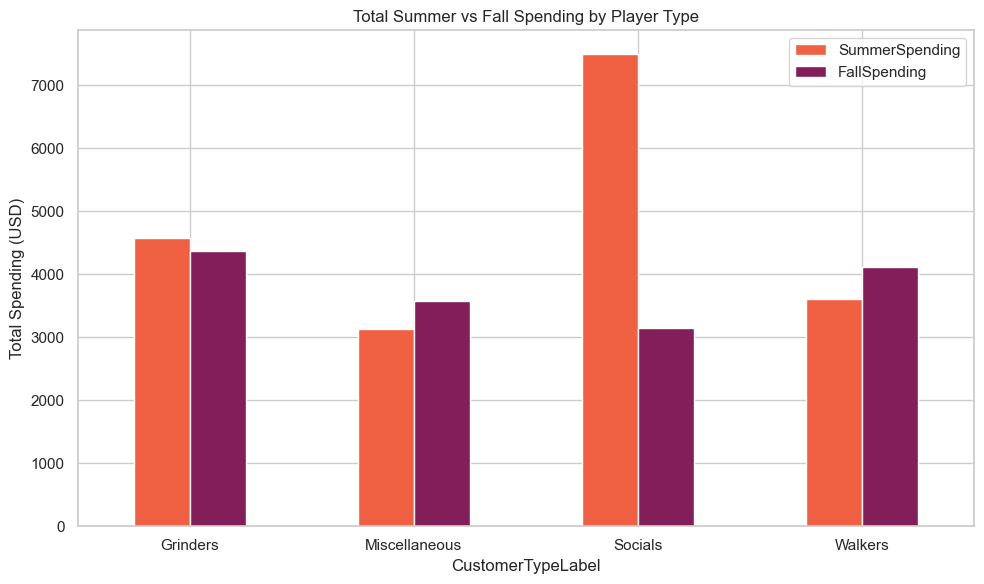

In [123]:
colors = sns.color_palette("rocket_r", 2)

spend_sum = merged.groupby("CustomerTypeLabel")[["SummerSpending", "FallSpending"]].sum().reset_index()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
spend_sum.set_index("CustomerTypeLabel")[["SummerSpending", "FallSpending"]].plot(
    kind="bar",
    stacked=False,
    color=colors,
    figsize=(10, 6)
)

plt.title("Total Summer vs Fall Spending by Player Type")
plt.ylabel("Total Spending (USD)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 📊 Spending Comparison by Player Type (Summer vs Fall)

This bar chart shows total player spending across Summer and Fall for each player type.

### 🧠 Key Insights:

- **Grinders**:  
  Spending remains high and stable from Summer to Fall.

- **Socials**:  
  Spending drops significantly in Fall, indicating reduced monetization from social players.

- **Walkers**:  
  Slight increase in spending during Fall, suggesting steady engagement.

- **Miscellaneous**:  
  Spending levels remain relatively low and stable across seasons.

### 🎯 Strategic Recommendations:

1. **Focus on Grinders**:  
   Strengthen loyalty programs and offers to maintain Grinders’ high spending.

2. **Re-activate Socials**:  
   Create social-driven promotions or bundles to regain spending from Social players.

3. **Encourage Walkers**:  
   Incentivize Walkers further through special seasonal offers to boost their growing spending behavior.

### Player Types vs Summer Game Time (Violin Plot)

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2888074718.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2888074718.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



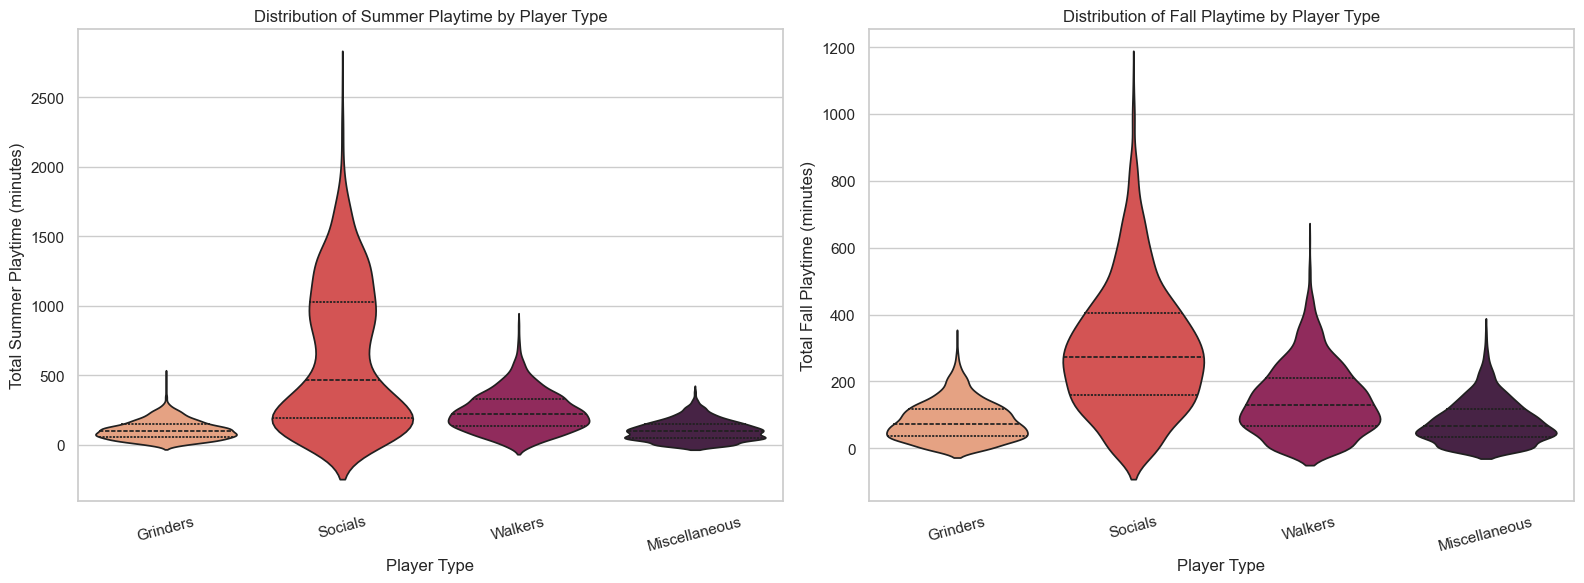

In [126]:
violin_palette = sns.color_palette("rocket_r", 4)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1行2列

# 第一个 subplot - Summer Playtime
sns.violinplot(
    data=merged,
    x="CustomerTypeLabel",
    y="SummerPlaytime",
    inner="quartile",
    palette=violin_palette,
    ax=axes[0]
)
axes[0].set_title("Distribution of Summer Playtime by Player Type")
axes[0].set_ylabel("Total Summer Playtime (minutes)")
axes[0].set_xlabel("Player Type")
axes[0].tick_params(axis='x', rotation=15)

# 第二个 subplot - Fall Playtime
sns.violinplot(
    data=merged,
    x="CustomerTypeLabel",
    y="FallPlaytime",
    inner="quartile",
    palette=violin_palette,
    ax=axes[1]
)
axes[1].set_title("Distribution of Fall Playtime by Player Type")
axes[1].set_ylabel("Total Fall Playtime (minutes)")
axes[1].set_xlabel("Player Type")
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

### 📊 Playtime Distribution by Player Type (Summer vs Fall)

The violin plots show total playtime distributions across player types in Summer and Fall.


### 🧠 Key Insights:

- **Socials**:  
  Social players have the longest playtimes in both seasons, but experience a notable drop in Fall.

- **Walkers and Grinders**:  
  Walkers and Grinders maintain more consistent playtime across seasons.

- **Miscellaneous**:  
  Playtimes are generally lower and more compact for Miscellaneous players.


### 🎯 Strategic Recommendations:

1. **Protect Socials’ Engagement**:  
   Launch retention campaigns targeting Social players, especially during Fall.

2. **Support Core Groups**:  
   Continue optimizing experiences for Walkers and Grinders to maintain stable playtimes.

3. **Personalize Playtime Rewards**:  
   Offer time-based achievements or rewards to encourage longer sessions across all types.

### Age Group × User Lifecycle Analysis

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3110233328.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3110233328.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



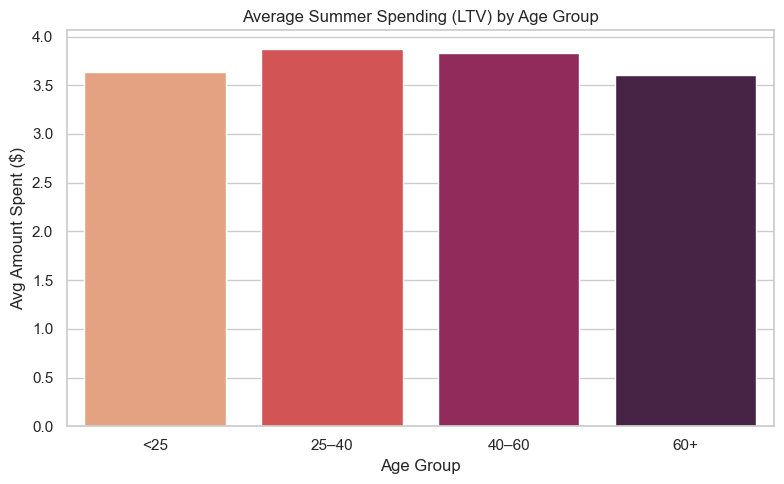

In [136]:
sns.set_theme(style="whitegrid", palette="rocket_r")

merged["AgeGroup"] = pd.cut(
    df_all["Age"],
    bins=[0, 25, 40, 60, 100],
    labels=["<25", "25–40", "40–60", "60+"]
)

ltv_by_age = merged.groupby("AgeGroup")["SummerSpending"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=ltv_by_age, x="AgeGroup", y="SummerSpending", palette="rocket_r")  # ✨改这里
plt.title("Average Summer Spending (LTV) by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Avg Amount Spent ($)")
plt.tight_layout()
plt.show()

### 📊 Average Summer Spending by Age Group

This bar chart shows the average summer spending (LTV) across different age groups.

### 🧠 Key Insights:

- **Younger Players Spend Slightly More**:  
  Players under 25 and those aged 25–40 spend slightly more on average than older groups.

- **Spending Declines with Age**:  
  Average spending gradually decreases for players aged 40 and above.

- **Relatively Small Variations**:  
  Differences between groups are present but not extremely large.

### 🎯 Strategic Recommendations:

1. **Focus on Younger Audiences**:  
   Continue targeting players under 40 with premium offers and events.

2. **Tailor Offers for Older Players**:  
   Introduce value-oriented bundles for players aged 40+ to boost engagement and spending.

3. **Monitor Lifetime Value (LTV)**:  
   Track spending patterns over time to adjust monetization strategies per age segment.

### Active vs Consumption (Scatter Plot, Identify Target Audience)

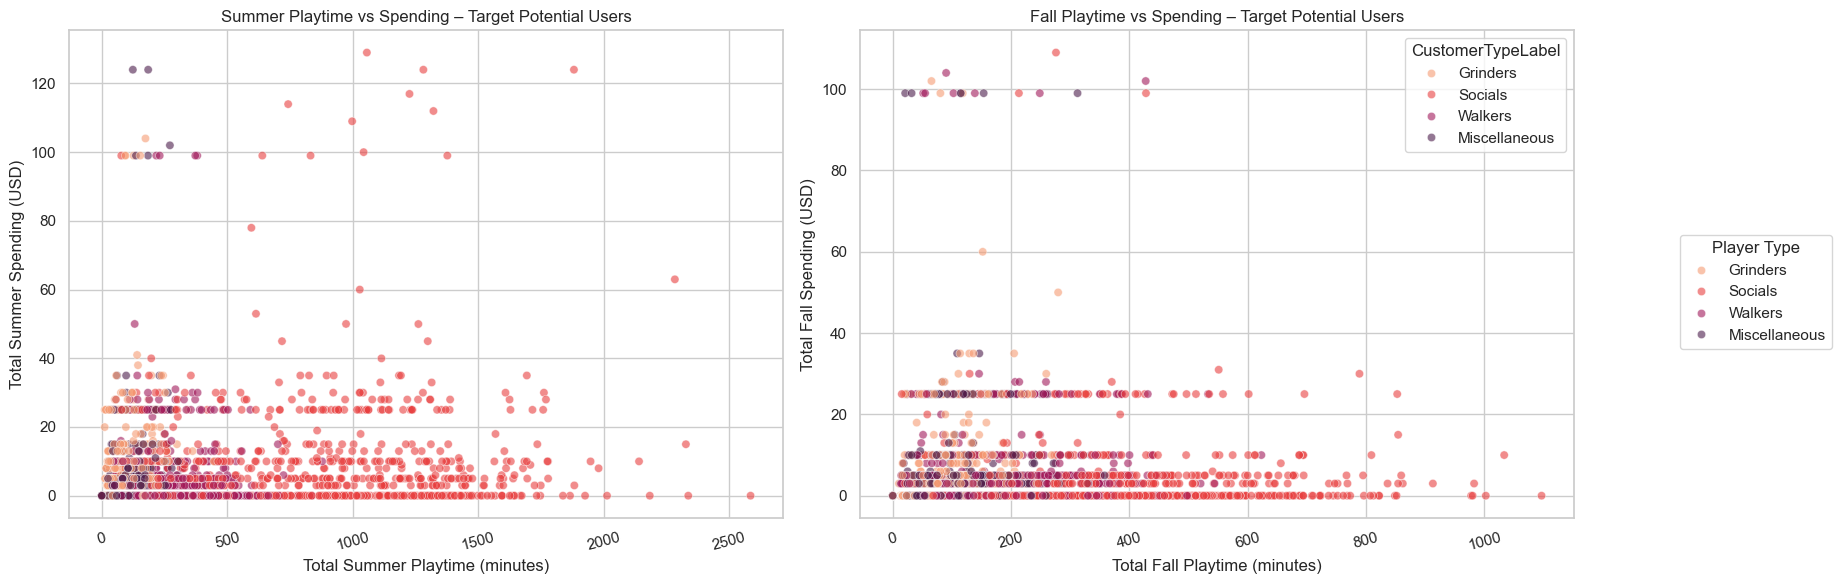

In [202]:
scatter_palette = sns.color_palette("rocket_r", 4)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  Summer
sns.scatterplot(
    data=merged,
    x="SummerPlaytime",
    y="SummerSpending",
    hue="CustomerTypeLabel",
    alpha=0.6,
    palette=scatter_palette,
    ax=axes[0]
)
axes[0].set_title("Summer Playtime vs Spending – Target Potential Users")
axes[0].set_xlabel("Total Summer Playtime (minutes)")
axes[0].set_ylabel("Total Summer Spending (USD)")
axes[0].legend_.remove()
axes[0].tick_params(axis='x', rotation=15)

#  Fall
sns.scatterplot(
    data=merged,
    x="FallPlaytime",
    y="FallSpending",
    hue="CustomerTypeLabel",
    alpha=0.6,
    palette=scatter_palette,
    ax=axes[1]
)
axes[1].set_title("Fall Playtime vs Spending – Target Potential Users")
axes[1].set_xlabel("Total Fall Playtime (minutes)")
axes[1].set_ylabel("Total Fall Spending (USD)")
axes[1].tick_params(axis='x', rotation=15)

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title="Player Type",
    bbox_to_anchor=(1.05, 0.5),
    loc='center left'
)

plt.tight_layout()
plt.show()

### 📊 Playtime vs Spending (Target Potential Users)

These scatter plots show the relationship between playtime and spending across player types in Summer and Fall.

### 🧠 Key Insights:

- **Positive Correlation**:  
  Players who play longer tend to spend more, but the relationship is not very strong.

- **Grinders Stand Out**:  
  Grinders are the primary group with high playtime and high spending potential.

- **Socials Behavior**:  
  Social players show moderate playtime but also occasional high spending.

### 🎯 Strategic Recommendations:

1. **Target High-Playtime Users**:  
   Focus marketing and VIP programs on players with extended playtime.

2. **Boost Socials’ Spending**:  
   Design offers encouraging moderate players (Socials) to increase their spending.

3. **Segment Marketing by Player Type**:  
   Personalize campaigns based on playtime and spending patterns to maximize conversion.

## Churn Analysis

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [146]:
customerdata = pd.read_csv("customerdata_case.csv", parse_dates=["Registrationdate"])
summersesstrx = pd.read_csv("summersesstrx_case.csv", parse_dates=["Date"])
fallsesstrx = pd.read_csv("fallsesstrx_case.csv", parse_dates=["Date"])
summerfintrx = pd.read_csv("summerfintrx_case.csv", parse_dates=["Date"])
fallfintrx = pd.read_csv("fallfintrx_case.csv", parse_dates=["Date"])

In [148]:
summer_users = set(summerfintrx["CustomerID"].unique())
fall_users = set(fallfintrx["CustomerID"].unique())
churned_users = summer_users - fall_users

# Label Churn
customerdata["Churn"] = customerdata["CustomerID"].apply(lambda x: 1 if x in churned_users else 0)

In [150]:
def process_session(df, tag):
    grouped = df.groupby("CustomerID").agg(
        total_sessions=("PlayID", "count"),
        avg_experience=("Experience", "mean"),
        avg_huntingcabins=("Huntingcabins", "mean"),
        avg_trainingschools=("Trainingschools", "mean"),
        avg_huntinggrounds=("Huntinggrounds", "mean"),
        avg_social=("Social", "mean")
    ).reset_index()
    grouped.columns = ["CustomerID"] + [f"{col}_{tag}" for col in grouped.columns[1:]]
    return grouped

summer_feat = process_session(summersesstrx, "summer")
fall_feat = process_session(fallsesstrx, "fall")

In [152]:
df = customerdata.merge(summer_feat, on="CustomerID", how="left") \
                    .merge(fall_feat, on="CustomerID", how="left")

for col in ["total_sessions", "avg_experience", "avg_huntingcabins", "avg_trainingschools", "avg_huntinggrounds", "avg_social"]:
    df[f"change_{col}"] = df[f"{col}_fall"].fillna(0) - df[f"{col}_summer"].fillna(0)

cols_to_copy = ["Age", "Income", "Gender", "CustomerType", "Registrationdate"]
for col in cols_to_copy:
    if col not in df.columns:
        df[col] = customerdata[col]

df.fillna(0, inplace=True)

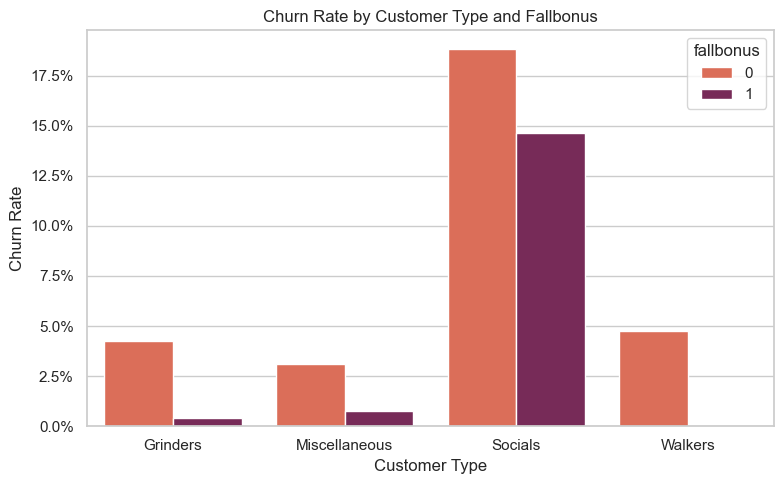

In [154]:
type_map = {1: "Walkers", 2: "Miscellaneous", 3: "Socials", 4: "Grinders"}
df["TypeLabel"] = df["CustomerType"].map(type_map)

if "fallbonus" not in df.columns:
    df["fallbonus"] = 0

type_churn = df.groupby(["TypeLabel", "fallbonus"]).agg(
    churn_rate=("Churn", "mean"),
    count=("CustomerID", "count")
).reset_index()

plt.figure(figsize=(8, 5))
palette = sns.color_palette("rocket_r", 2)

sns.barplot(
    data=type_churn,
    x="TypeLabel",
    y="churn_rate",
    hue="fallbonus",
    palette=palette
)

plt.title("Churn Rate by Customer Type and Fallbonus")
plt.ylabel("Churn Rate")
plt.xlabel("Customer Type")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 📊 Churn Rate by Customer Type and Fall Bonus

This bar chart shows the churn rate across player types, split by whether they received a Fall bonus.

### 🧠 Key Insights:

- **Socials Have Highest Churn**:  
  Social players show the highest churn rate, regardless of receiving a bonus.

- **Fall Bonus Helps**:  
  Players who received a Fall bonus generally have a lower churn rate, but the effect is not strong enough for Socials.

- **Grinders and Walkers**:  
  Grinders and Walkers have low churn rates overall, with slight improvement from bonuses.

### 🎯 Strategic Recommendations:

1. **Rethink Bonuses for Socials**:  
   Standard bonuses are not sufficient; consider personalized reactivation campaigns for Socials.

2. **Maintain Loyalty Programs**:  
   Continue rewarding Grinders and Walkers to maintain their already low churn rates.

3. **Segment Retention Strategies**:  
   Design different retention tactics per player type, considering bonus sensitivity.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/1218014392.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



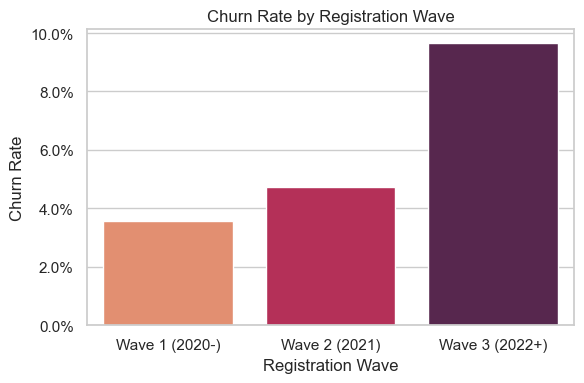

In [156]:
df["Wave"] = pd.to_datetime(df["Registrationdate"]).dt.year.map(
    lambda y: "Wave 1 (2020-)" if y <= 2020 else ("Wave 2 (2021)" if y == 2021 else "Wave 3 (2022+)")
)

wave_churn = df.groupby("Wave")["Churn"].mean().reset_index()

wave_order = ["Wave 1 (2020-)", "Wave 2 (2021)", "Wave 3 (2022+)"]

plt.figure(figsize=(6, 4))
palette = sns.color_palette("rocket_r", 3)

sns.barplot(data=wave_churn, x="Wave", y="Churn", order=wave_order, palette=palette)
plt.title("Churn Rate by Registration Wave")
plt.ylabel("Churn Rate")
plt.xlabel("Registration Wave")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

### 📊 Churn Rate by Registration Wave

This bar chart shows the churn rates by user registration cohorts (Wave 1: 2020-, Wave 2: 2021, Wave 3: 2022+).

### 🧠 Key Insights:

- **Newer Users Churn More**:  
  Users who registered more recently (Wave 3) have the highest churn rate.

- **Older Cohorts Are More Stable**:  
  Users registered before 2021 (Wave 1) show significantly lower churn.

- **Retention Decreases Over Time**:  
  As the game matures, newer users are harder to retain compared to early adopters.

### 🎯 Strategic Recommendations:

1. **Onboarding Optimization**:  
   Enhance the onboarding process to better retain new users from Wave 3.

2. **Early Engagement Focus**:  
   Increase early-stage engagement (first week or month) to reduce early churn.

3. **Cohort-Based Retention Programs**:  
   Design targeted retention strategies based on the registration wave.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2272066184.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2272066184.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



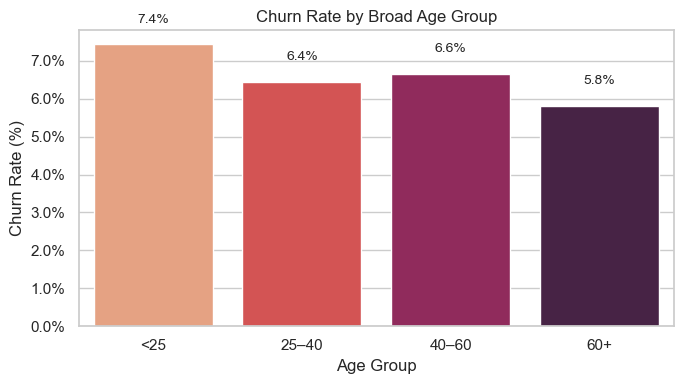

In [158]:
df["AgeGroup"] = pd.cut(
    df["Age"],
    bins=[0, 25, 40, 60, 100],
    labels=["<25", "25–40", "40–60", "60+"]
)

age_churn = df.groupby("AgeGroup")["Churn"].mean().reset_index()
age_churn["Churn"] *= 100

plt.figure(figsize=(7, 4))
palette = sns.color_palette("rocket_r", 4)

barplot = sns.barplot(data=age_churn, x="AgeGroup", y="Churn", palette=palette)
plt.title("Churn Rate by Broad Age Group")
plt.xlabel("Age Group")
plt.ylabel("Churn Rate (%)")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

for i, val in enumerate(age_churn["Churn"]):
    barplot.text(i, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### 📊 Churn Rate by Broad Age Group

This bar chart shows the churn rates segmented by broad age groups: <25, 25-40, 40-60, and 60+.

### 🧠 Key Insights:

- **Younger Players (<25)** have the **highest churn rate (7.4%)**.
- **Older Players (60+)** are the **most stable**, with the **lowest churn (5.8%)**.
- **Middle-aged groups (25-60)** show **moderate churn** around 6.4%-6.6%.

### 🎯 Strategic Recommendations:

1. **Focus on Retaining Younger Users**:  
   Design faster engagement loops and more dynamic experiences for <25 players.

2. **Reward Loyalty for Older Users**:  
   Create loyalty programs for 40+ players to reinforce long-term retention.

3. **Age-Based Personalization**:  
   Personalize campaigns and offers by age group to maximize retention.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/1678936326.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


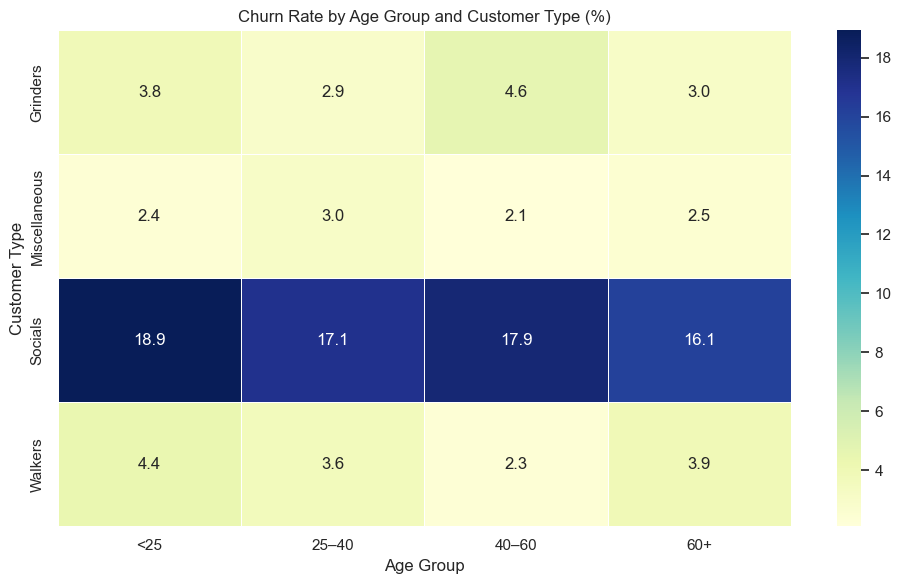

In [211]:
type_map = {1: "Walkers", 2: "Miscellaneous", 3: "Socials", 4: "Grinders"}
df["TypeLabel"] = df["CustomerType"].map(type_map)

age_type_churn = df.groupby(["AgeGroup", "TypeLabel"])["Churn"].mean().unstack().T * 100

plt.figure(figsize=(10,6))
sns.heatmap(age_type_churn, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5)
plt.title("Churn Rate by Age Group and Customer Type (%)")
plt.xlabel("Age Group")
plt.ylabel("Customer Type")
plt.tight_layout()
plt.show()

### 📊 Churn Rate by Age Group & Customer Type (Heatmap)

This heatmap visualizes the churn rate (%) across different age groups and customer types.

### 🧠 Key Insights:

- **Social Players** have **highest churn across all age groups** (~16%-19%).
- **Grinders** and **Walkers** maintain **low churn** across all ages (~3%-5%).
- **Miscellaneous Players** have the **lowest churn** (~2%-3%).

### 🎯 Strategic Recommendations:

1. **Focus Retention on Social Players**:  
   Create loyalty programs, bonus content, or personalized campaigns for Socials.

2. **Differentiate by Age Group**:  
   Younger Social players (<25) churn the most (18.9%), need more early-game engagement.

3. **Protect Loyal Segments**:  
   Continue reinforcing positive behaviors for Grinders and Walkers with rewards.

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2183364203.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2183364203.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



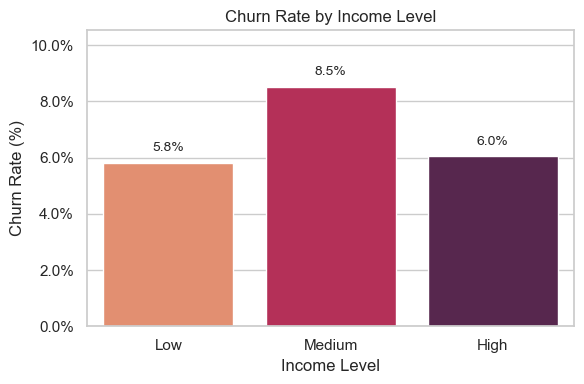

In [162]:
df["IncomeLabel"] = df["Income"].map({1: "Low", 2: "Medium", 3: "High"})
df["IncomeLabel"] = pd.Categorical(df["IncomeLabel"], categories=["Low", "Medium", "High"], ordered=True)

income_churn = df.groupby("IncomeLabel").agg(
    churn_rate=("Churn", "mean")
).reset_index()
income_churn["churn_rate"] *= 100

plt.figure(figsize=(6, 4))
palette = sns.color_palette("rocket_r", 3)

barplot = sns.barplot(data=income_churn, x="IncomeLabel", y="churn_rate", palette=palette)
plt.title("Churn Rate by Income Level")
plt.ylabel("Churn Rate (%)")
plt.xlabel("Income Level")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylim(0, income_churn["churn_rate"].max() + 2)

for i, val in enumerate(income_churn["churn_rate"]):
    barplot.text(i, val + 0.3, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/1992626467.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



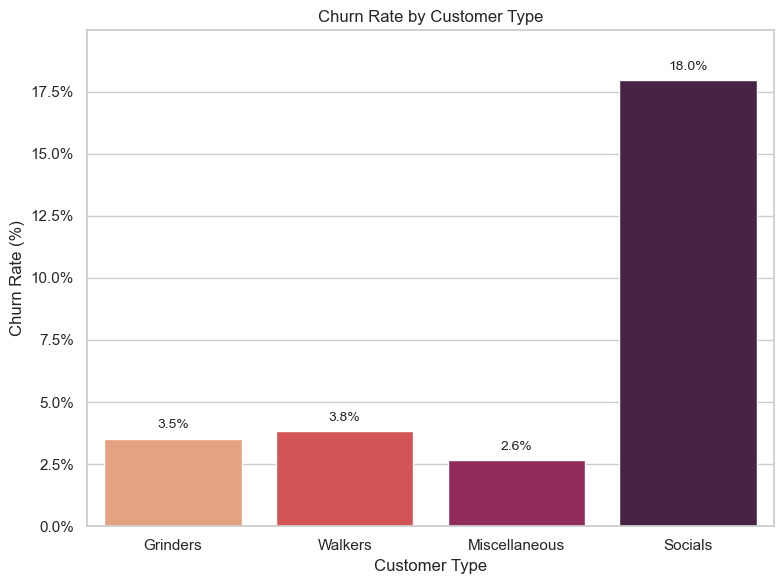

In [164]:
churn_by_type = df.groupby("TypeLabel")["Churn"].mean() * 100
churn_by_type = churn_by_type.reset_index()

order = ["Grinders", "Walkers", "Miscellaneous", "Socials"]

plt.figure(figsize=(8, 6))
palette = sns.color_palette("rocket_r", len(order))

barplot = sns.barplot(
    data=churn_by_type,
    x="TypeLabel",
    y="Churn",
    order=order,
    palette=palette
)

plt.title("Churn Rate by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Churn Rate (%)")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylim(0, churn_by_type["Churn"].max() + 2)

for i, val in enumerate(churn_by_type.set_index("TypeLabel").loc[order]["Churn"]):
    barplot.text(i, val + 0.3, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2933052901.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



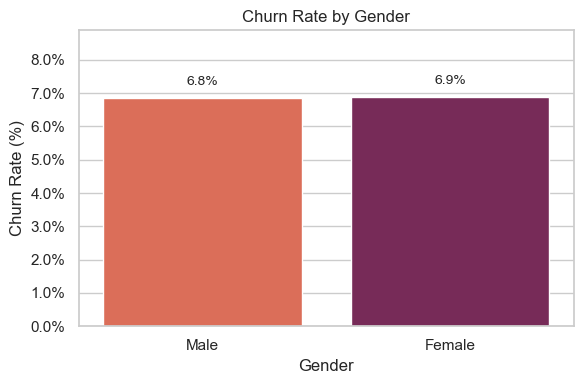

In [166]:
churn_by_gender = df.groupby("Gender")["Churn"].mean() * 100
churn_by_gender = churn_by_gender.reset_index()
churn_by_gender["GenderLabel"] = churn_by_gender["Gender"].map({0: "Male", 1: "Female"})

plt.figure(figsize=(6, 4))
palette = sns.color_palette("rocket_r", 2)

barplot = sns.barplot(
    data=churn_by_gender,
    x="GenderLabel",
    y="Churn",
    palette=palette
)

plt.title("Churn Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Churn Rate (%)")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylim(0, churn_by_gender["Churn"].max() + 2)

for i, val in enumerate(churn_by_gender["Churn"]):
    barplot.text(i, val + 0.3, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2237840855.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/2237840855.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



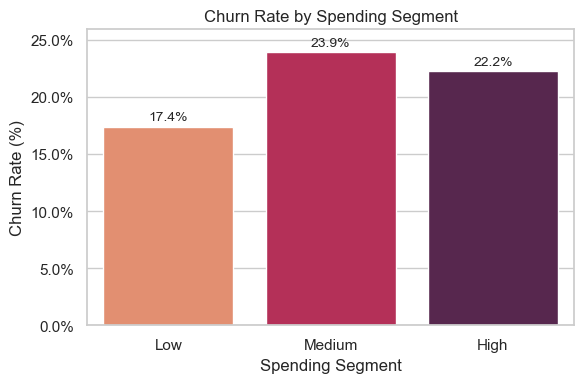

In [168]:
summerfintrx["AmountSpent"] = summerfintrx["ProductID"].map({
    1: 2.99, 2: 4.99, 3: 9.99, 4: 25.00, 5: 99.00
})

spending = summerfintrx.groupby("CustomerID")["AmountSpent"].sum().reset_index()

spending["SpendingSegment"] = pd.qcut(
    spending["AmountSpent"], 
    3, 
    labels=["Low", "Medium", "High"]
)

df = df.merge(spending[["CustomerID", "SpendingSegment"]], on="CustomerID", how="left")

churn_by_segment = df.groupby("SpendingSegment")["Churn"].mean().reset_index()
churn_by_segment["Churn"] *= 100

plt.figure(figsize=(6, 4))
palette = sns.color_palette("rocket_r", 3)

barplot = sns.barplot(
    data=churn_by_segment,
    x="SpendingSegment",
    y="Churn",
    order=["Low", "Medium", "High"],
    palette=palette
)

plt.title("Churn Rate by Spending Segment")
plt.xlabel("Spending Segment")
plt.ylabel("Churn Rate (%)")

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylim(0, churn_by_segment["Churn"].max() + 2)

for i, val in enumerate(churn_by_segment["Churn"]):
    barplot.text(i, val + 0.3, f"{val:.1f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [170]:
df["IncomeLabel"] = df["Income"].map({1: "Low", 2: "Medium", 3: "High"})
df["IncomeLabel"] = pd.Categorical(df["IncomeLabel"], categories=["Low", "Medium", "High"], ordered=True)

In [172]:
churn_pivot = df.groupby(["IncomeLabel", "TypeLabel"])["Churn"].mean().unstack().T * 100

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/4277033457.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_29145/3495779410.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


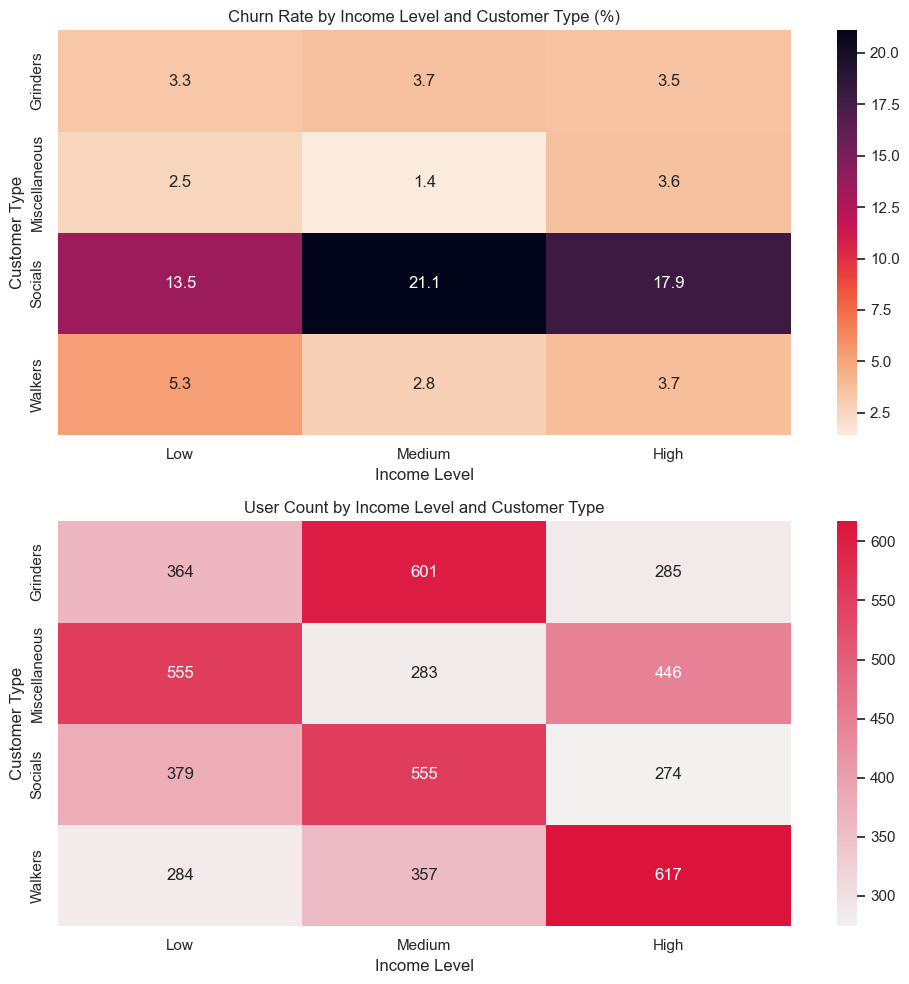

In [174]:
churn_count = df.groupby(["TypeLabel", "IncomeLabel"])["CustomerID"].count().unstack()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Churn Rate Heatmap
sns.heatmap(
    churn_pivot,
    annot=True,
    fmt=".1f",
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    ax=axes[0]
)
axes[0].set_title("Churn Rate by Income Level and Customer Type (%)")
axes[0].set_xlabel("Income Level")
axes[0].set_ylabel("Customer Type")

# Customer Count Heatmap
sns.heatmap(
    churn_count,
    annot=True,
    fmt=".0f",
    cmap=sns.light_palette("crimson", as_cmap=True),  # 或 "rocket"
    ax=axes[1]
)
axes[1].set_title("User Count by Income Level and Customer Type")
axes[1].set_xlabel("Income Level")
axes[1].set_ylabel("Customer Type")

plt.tight_layout()
plt.show()

## Customer Lifecycle Management: Churn Rate and User Distribution Analysis

### Overview

This analysis focuses on two key heatmaps:
- **Churn Rate by Income Level and Customer Type (%)**
- **User Count by Income Level and Customer Type**

These visualizations help to identify how different customer types and income levels influence churn behavior and user distribution.

### 1. Churn Rate by Income Level and Customer Type (%)

- **Socials** have the highest churn rates across all income levels, especially in the **Medium Income** group (21.1% churn).
- **Miscellaneous** players maintain relatively **low churn rates** across all income levels (around 1.4% to 3.6%).
- **Grinders** and **Walkers** have moderate churn rates, generally between 2.8% and 5.3%.
- Across all customer types, the **Medium Income group** tends to have slightly higher churn compared to Low or High income, particularly for **Socials**.

#### Key Insight:
- **Social players with Medium Income** show **critical churn risk** and should be targeted first for retention efforts.
- **Miscellaneous players** are the most stable group.

### 2. User Count by Income Level and Customer Type

- **Walkers** have the largest number of High Income users (617 users).
- **Grinders** and **Socials** are more evenly spread between Low and Medium income levels.
- **Miscellaneous** users are relatively balanced across Low and High incomes.

#### Key Insight:
- **Social players in the Medium Income group**, despite showing **high churn rates**, have a **large enough user base** (555 users), making them a **high-impact retention target**.
- **Walkers with High Income** form a significant portion of the user base and maintaining their loyalty is important.

### Strategic Recommendations

- Focus **retention campaigns** on **Medium Income Social players** using loyalty bonuses or targeted re-engagement programs.
- Monitor **Walkers** closely as they have a large High Income group that could be valuable for premium upsell offers.
- Use differentiated marketing: **Aggressive for Socials** (especially Medium Income), **lighter touch for Miscellaneous** and **Walkers**.

## Churn Prediction
#### Definition of Churn  
We define churn as: a player has a total gameplay duration of 0 in the fall season. When this condition is met, the player is considered to have churned.  

#### Building the Training Dataset  
- **Features (X)**: Use player behavior and spending features from the summer season as input.  
- **Labels (y)**: Use "churn status" as the target variable for prediction.  

#### Modeling and Evaluation  
- Use a logistic regression model for initial modeling.  
   - Other models, such as XGBoost, can be explored later.  
- Evaluate model performance:  
   - Output accuracy, recall, and AUC (area under the curve).  
   - Identify important features to understand the factors influencing player churn.  

In [177]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [179]:
customerdata = pd.read_csv('customerdata_case.csv',parse_dates=['Registrationdate'])

summersesstrx = pd.read_csv('summersesstrx_case.csv',parse_dates=['Date'])
summerfintrx = pd.read_csv('summerfintrx_case.csv',parse_dates=['Date'])

fallfintrx = pd.read_csv('fallfintrx_case.csv',parse_dates=['Date'])
fallsesstrx = pd.read_csv('fallsesstrx_case.csv',parse_dates=['Date'])

In [181]:
#Define Churn customers
summer_customers = set(summerfintrx["CustomerID"].unique())
fall_customers = set(fallfintrx["CustomerID"].unique())
churned_customers = summer_customers - fall_customers
customerdata["Churn"] = customerdata["CustomerID"].apply(lambda x: 1 if x in churned_customers else 0)

In [183]:
def process_sessions(df, period):
    features = df.groupby("CustomerID").agg(
        total_sessions=("PlayID", "count"),
        avg_experience=("Experience", "mean"),
        avg_huntingcabins=("Huntingcabins", "mean"),
        avg_trainingschools=("Trainingschools", "mean"),
        avg_huntinggrounds=("Huntinggrounds", "mean"),
        avg_social=("Social", "mean")
    ).reset_index()
    features.columns = ["CustomerID"] + [f"{col}_{period}" for col in features.columns[1:]]
    return features

summer_features = process_sessions(summersesstrx, "summer")
fall_features = process_sessions(fallsesstrx, "fall")

# Merge all behavioral characteristics
data = customerdata.merge(summer_features, on="CustomerID", how="left").merge(fall_features, on="CustomerID", how="left")

# Differential characteristics (fall - summer)
for col in ["total_sessions", "avg_experience", "avg_huntingcabins", "avg_trainingschools", "avg_huntinggrounds", "avg_social"]:
    data[f"change_{col}"] = data[f"{col}_fall"].fillna(0) - data[f"{col}_summer"].fillna(0)

In [185]:
target = "Churn"
features = [col for col in data.columns if col not in ["CustomerID", "Churn", "Registrationdate"]]
X = data[features].fillna(0)
y = data[target]

# Divide the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [187]:
# SMOTE oversampling
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBoost Model
xgb = XGBClassifier(
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=3,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train_resampled, y_train_resampled)

# Logistic regression
logreg = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=3000, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)

# Voting ensemble model
ensemble = VotingClassifier(
    estimators=[('xgb', xgb), ('logreg', logreg)],
    voting='soft',
    weights=[3, 1]
)
ensemble.fit(X_train_resampled, y_train_resampled)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constrai...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=400, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('logreg',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=3000, random_state=42,
                                                 solver='liblinear'))],
                 voting='soft', weights=[3, 1])

In [188]:
# Predicted probability
y_probs = ensemble.predict_proba(X_test)[:, 1]
final_threshold = 0.35
y_pred_final = (y_probs >= final_threshold).astype(int)

# Classification report
print(f"Final Threshold: {final_threshold:.2f}")
print(classification_report(y_test, y_pred_final))

# AUC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.2f}")

Final Threshold: 0.35
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       931
           1       0.17      0.35      0.23        69

    accuracy                           0.84      1000
   macro avg       0.56      0.61      0.57      1000
weighted avg       0.89      0.84      0.86      1000

AUC Score: 0.71


### Key Observations

- **High Accuracy** (84%) primarily comes from the correct classification of the majority class (Class 0).
- **Minority Class (1) Detection**:
  - Still challenging, with low precision and moderate recall.
  - Indicates many false positives, but more true positives compared to using a higher threshold.
- **Macro vs Weighted Metrics**:
  - The macro average is lower because it equally weighs both classes.
  - Weighted average is higher because class 0 dominates the dataset.

### Recommendations

- **Further threshold tuning**: Explore different thresholds to better balance precision and recall for Class 1.
- **Class rebalancing**: Apply techniques like **SMOTE**, **undersampling**, or **cost-sensitive learning**.
- **Model enhancements**: Try more powerful models or ensemble techniques focused on minority class performance (e.g., XGBoost with `scale_pos_weight`).

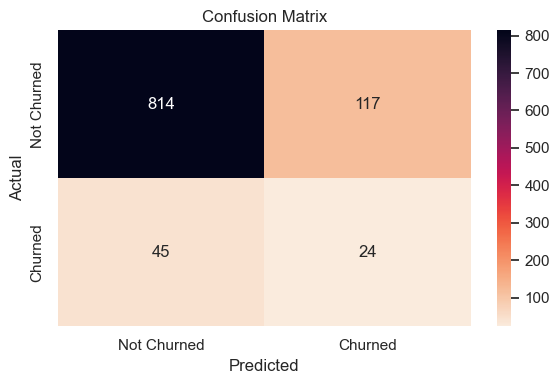

In [189]:
cm = confusion_matrix(y_test, y_pred_final)

cmap = sns.color_palette("rocket_r", as_cmap=True)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=cmap,
    xticklabels=["Not Churned", "Churned"],
    yticklabels=["Not Churned", "Churned"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Key Observations

- **High TN (814)**: Model is good at identifying users who are not churning.
- **Low TP (24)**: Model struggles to identify actual churners.
- **Moderate FP (117)**: Some users incorrectly flagged for churn.
- **Moderate FN (45)**: Many churners missed (false negatives are critical in churn prediction).

### Insights

- **Churn Detection Challenge**: The low number of true positives (24 out of 69 churned users) reflects the difficulty in detecting churn accurately.
- **Imbalance Impact**: Because churners are the minority class, even a slight misclassification hurts model recall and business actions.
- **Business Risk**:
  - **False Negatives** (missed churners) could lead to revenue loss.
  - **False Positives** could waste retention resources.

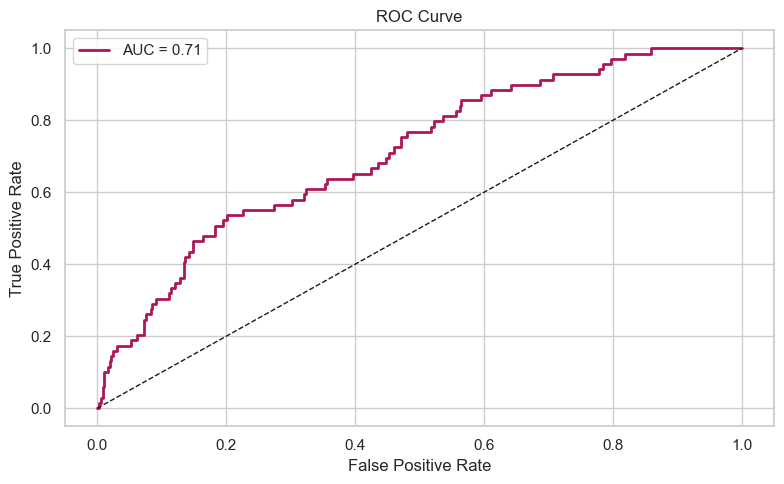

In [190]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

roc_color = sns.color_palette("rocket_r")[3]

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color=roc_color, linewidth=2, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Understanding the ROC Curve

The ROC (Receiver Operating Characteristic) curve plots:
- **True Positive Rate (Recall)** on the y-axis
- **False Positive Rate** on the x-axis

The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the model.

### Interpretation

- **AUC = 0.71** indicates that the model has a **fair ability** to distinguish between churners and non-churners.

### Insights

- The ROC curve is **above the diagonal line** (random classifier), which confirms the model is **better than random**.
- However, the curve is not very close to the top-left corner, suggesting the model is **moderately good** but could improve at separating churners from non-churners.

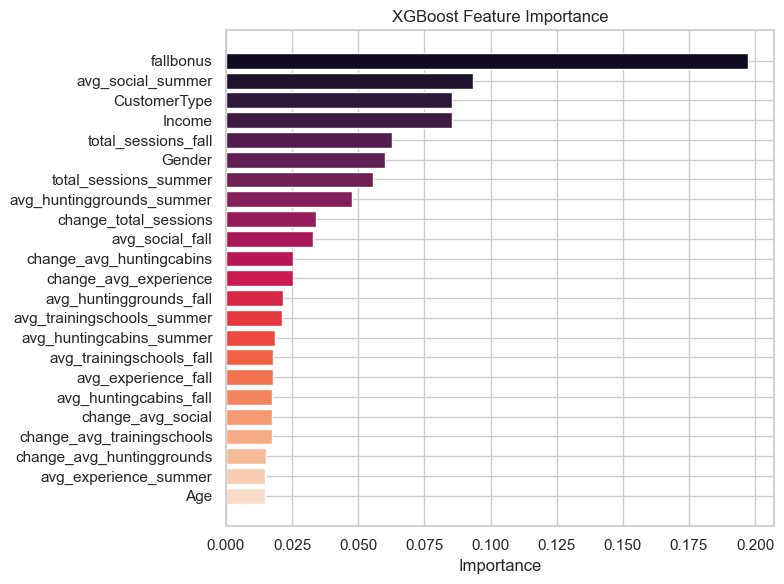

In [192]:
feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb.feature_importances_
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(8, 6))
colors = sns.color_palette("rocket_r", len(feat_imp))
plt.barh(feat_imp["Feature"], feat_imp["Importance"], color=colors)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### Overview

The bar plot above displays the **relative importance** of each feature in predicting churn, as determined by the trained **XGBoost model**. Feature importance is measured by how often and effectively a feature is used to split the data across all decision trees in the model.

### Key Insights

- **Fall Bonus (`fallbonus`)**:  
  The most critical feature. Players receiving a bonus are significantly less likely to churn, highlighting the **strong impact of incentives**.

- **Social Engagement (`avg_social_summer`)**:  
  Socially active players in summer are more retained, suggesting **community interactions** play a vital role.

- **Customer Type (`CustomerType`)**:  
  Different types of players (Walkers, Socials, etc.) exhibit different churn behaviors. Tailored strategies per type are essential.

- **Income**:  
  Players' income levels are important. **Higher income** may correlate with more consistent engagement or spending patterns.

- **Fall Activity (`total_sessions_fall`)**:  
  The total activity during Fall strongly predicts churn. Players who remain active in Fall are more likely to stay.

### Lower Importance Features

- Features like **Age**, **avg_experience_summer**, and **change_avg_huntinggrounds** show **relatively low importance**.  
- This suggests that **demographic factors (like Age)** or minor activity changes are **less predictive** compared to direct engagement metrics and incentives.

## Summary

Through a comprehensive analysis, several key insights were uncovered:

- **Age and Income Analysis**:  
  Most players fall within the 20–40 age range, and players across different income levels show distinct engagement and churn patterns.

- **Player Type Segmentation**:  
  "Socials" exhibited higher churn rates, especially without bonuses, while "Grinders" maintained more consistent engagement across seasons.

- **Session and Spending Behavior**:  
  Summer and Fall sessions and spending patterns varied significantly, highlighting seasonality effects on player activity.

- **Churn Analysis**:  
  Players who received bonuses in Fall showed significantly lower churn rates. Recent registrants (Wave 3) exhibited higher churn compared to earlier cohorts.

- **Predictive Modeling**:  
  An **XGBoost model** was trained, achieving an **AUC score of 0.71**, indicating moderate predictive power.  
  The most important features for predicting churn were:
  - `fallbonus`
  - `avg_social_summer`
  - `CustomerType`
  - `Income`
  - `total_sessions_fall`

- **Retention Strategy Recommendations**:
  - Increase bonus incentives, especially for social players.
  - Focus on boosting social engagement during Summer to improve Fall retention.
  - Tailor retention campaigns based on player type and income segmentation.

This analysis provides clear pathways to design **targeted marketing strategies**, **personalized offers**, and **player lifecycle management** initiatives to **enhance customer retention** and **maximize lifetime value**.


*End of Customer Lifecycle Management Analysis.*
·